In [92]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures as mp
from typing import Union
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy import optimize
from feynman import Diagram

Sources:

https://cds.cern.ch/record/2257069?ln=en

https://atlas.physicsmasterclasses.org/en/zpath_lhcphysics2.htm

inspiração para filtros:

https://github.com/Introducao-AnaliseDados-FAE/IntroducaoAnalisedeDadosFAE-2024_02/blob/main/material/aula_8/aulaMatheusCosta_26Nov2024.pdf


fonte para os labels dos dados:

https://cms-opendata-workshop.github.io/workshop2024-lesson-physics-objects/aio.html

para luminosidade (?):

https://cms-opendata-guide.web.cern.ch/analysis/lumi/


In [2]:
FILTER_MASS = True
MASS_MIN = 60
MASS_MAX = 120
BINS = 30
DPI = 500

def inv_mass(ak_vec1: ak.Array, ak_vec2: ak.Array) -> ak.Array:
    return ak.flatten(np.sqrt(
        2 * ak_vec1.pt * ak_vec2.pt * (np.cosh(ak_vec1.eta - ak_vec2.eta) - np.cos(ak_vec1.phi - ak_vec2.phi))
    ))

def expand(ak_array: ak.Array) -> tuple[ak.Array, ak.Array]:
    pairs = ak.combinations(ak_array, 2)
    return ak.unzip(pairs)

def inv_mass_expand(ak_array: ak.Array) -> ak.Array:
    vec1, vec2 = expand(ak_array)
    mass = inv_mass(vec1, vec2)
    if FILTER_MASS:
        mass = mass[(mass > MASS_MIN) & (mass < MASS_MAX)]
    return mass

def generete_data(file_path: str, branches: list[str]) -> ak.Array:
    with uproot.open(file_path) as file:
        tree = file['Events']
        arrays = {branch.split("_")[-1].lower(): tree[branch].array() for branch in branches}
    return ak.zip(arrays)

def hist_plot(ak_array: Union[ak.Array, np.ndarray],
              column_name: str,
              display_name: str = None, **kwargs):
    plt.hist(ak.flatten(ak_array[column_name]) if isinstance(ak_array, ak.Array) else ak_array, **kwargs)
    plt.xlabel(display_name if display_name else column_name)
    plt.ylabel("Eventos")

def generate_points(mass):
    """
    TODO: Adicionar erro
    
    como é calculado:

    ele pega cada bin criado, de cada bin, pegamos o máximo e o mínimo, e calculamos a média
    por isso fica um "pontinho" no meio do bin.

    nesse caso o scatter plot é feito:
    x = bin_centers (média explicada acima)
    y = freq (quantidade de eventos no bin)
    """
    hist_counts, bin_edges = np.histogram(mass, bins=BINS)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    return bin_centers, hist_counts

Fonte dos dados:

https://opendata.cern.ch/record/35669

https://opendata.cern.ch/record/30522

In [3]:
data = "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/30000/0082C29D-E74C-024A-BE9B-97B29EE7A4A2.root" 
realdata = "root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/05DD095C-F6C3-9A4F-9FB3-348A5A6403D5.root"

colunas que iremos selecionar:

In [4]:
branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "nMuon", "Muon_tkRelIso", "Muon_sip3d"]

# significado de cada coluna:
# muon_pt: Momento transverso do múon
# muon_eta: Pseudorapidez do múon - invariante sob transformações de Lorentz na direção do feixe.
# muon_phi: Ângulo azimutal do múon
# muon_charge: Carga do múon (1 ou -1)
# nMuon: Número de múons no evento
# muon_tkRelIso: Isolamento relativo do múon
# muon_sip3d: Parâmetro de impacto do múon - se veio de um vérice primário ou de um decaimento secundário


In [5]:
vec_real = generete_data(realdata, branches)
vec = generete_data(data, branches)

quantidade de dados:

In [19]:
print(f"Real data: {len(vec_real)}")
print(f"Simulated data: {len(vec)}")

Real data: 2315223
Simulated data: 1933726


# Plots

aqui vamos plotar a comparação entre os dados simulados (MC) e os dados reais coletados pelo LHC

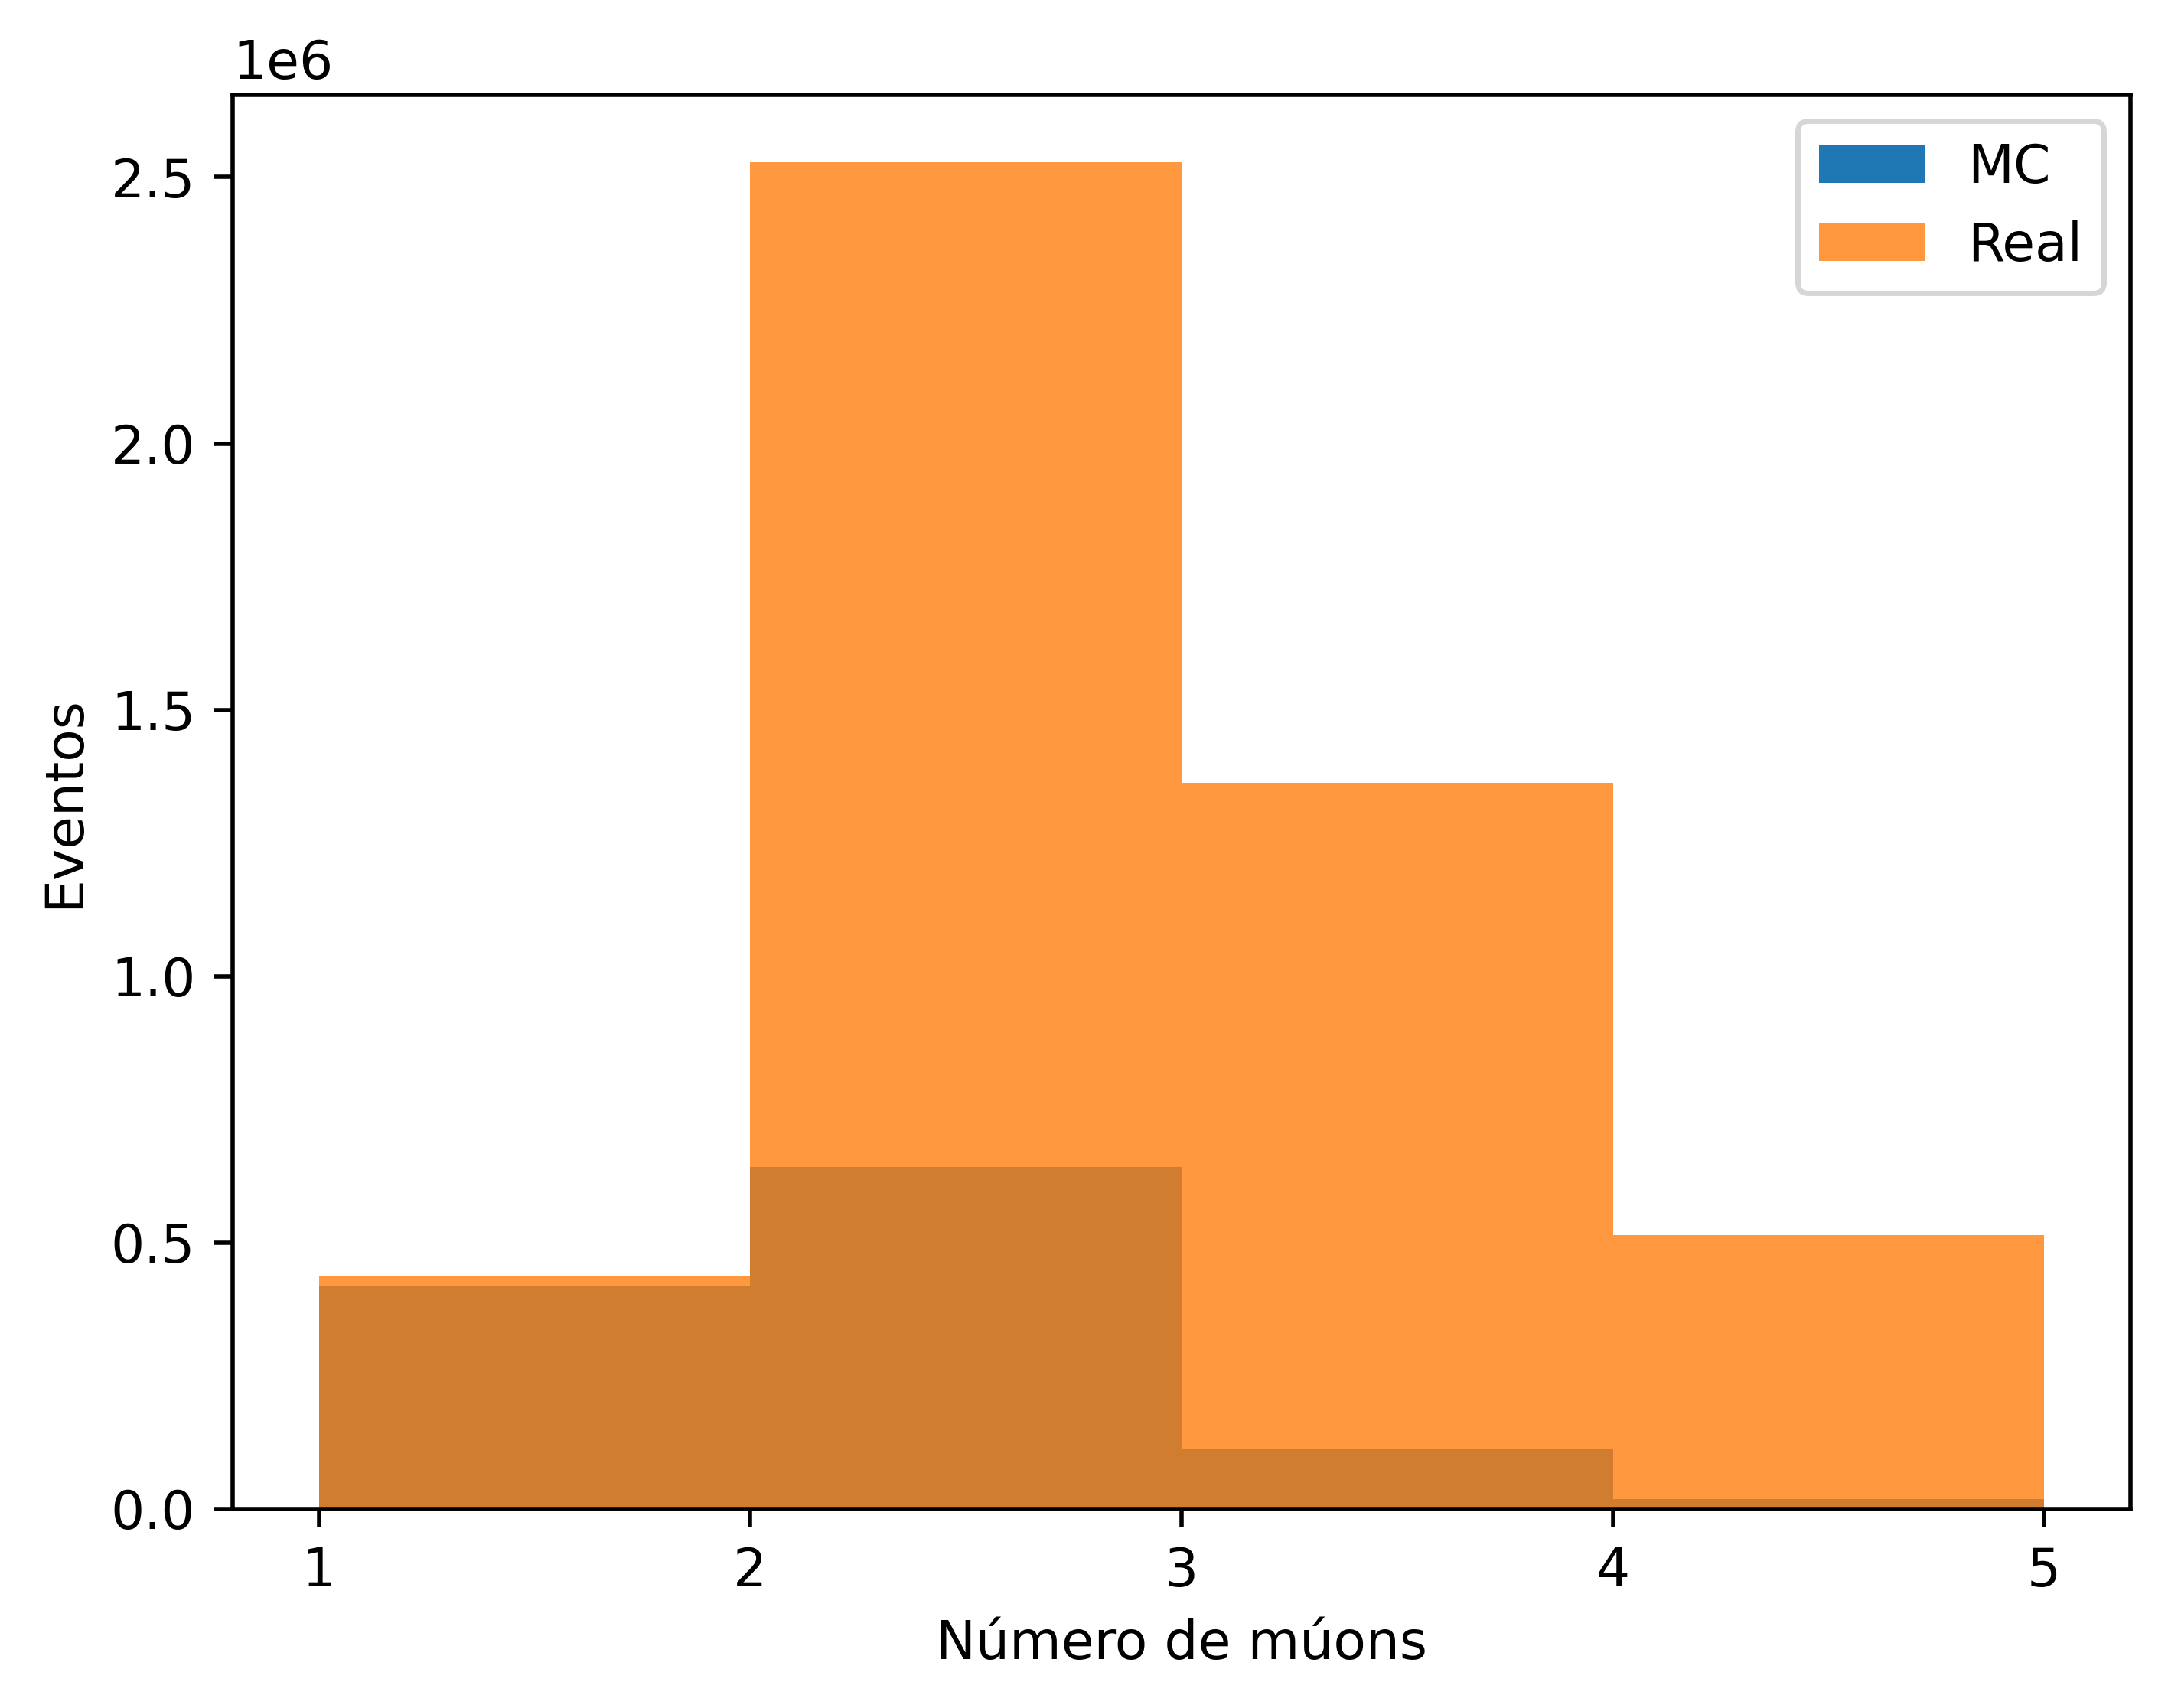

In [28]:
plt.figure(dpi=DPI)
hist_plot(vec, "nmuon", "Número de múons", label="MC",bins=4, range=(1, 5))
hist_plot(vec_real, "nmuon", "Número de múons", label="Real", alpha=0.8, bins=4, range=(1, 5))
plt.xticks(range(1, 6))
plt.legend()
plt.show()

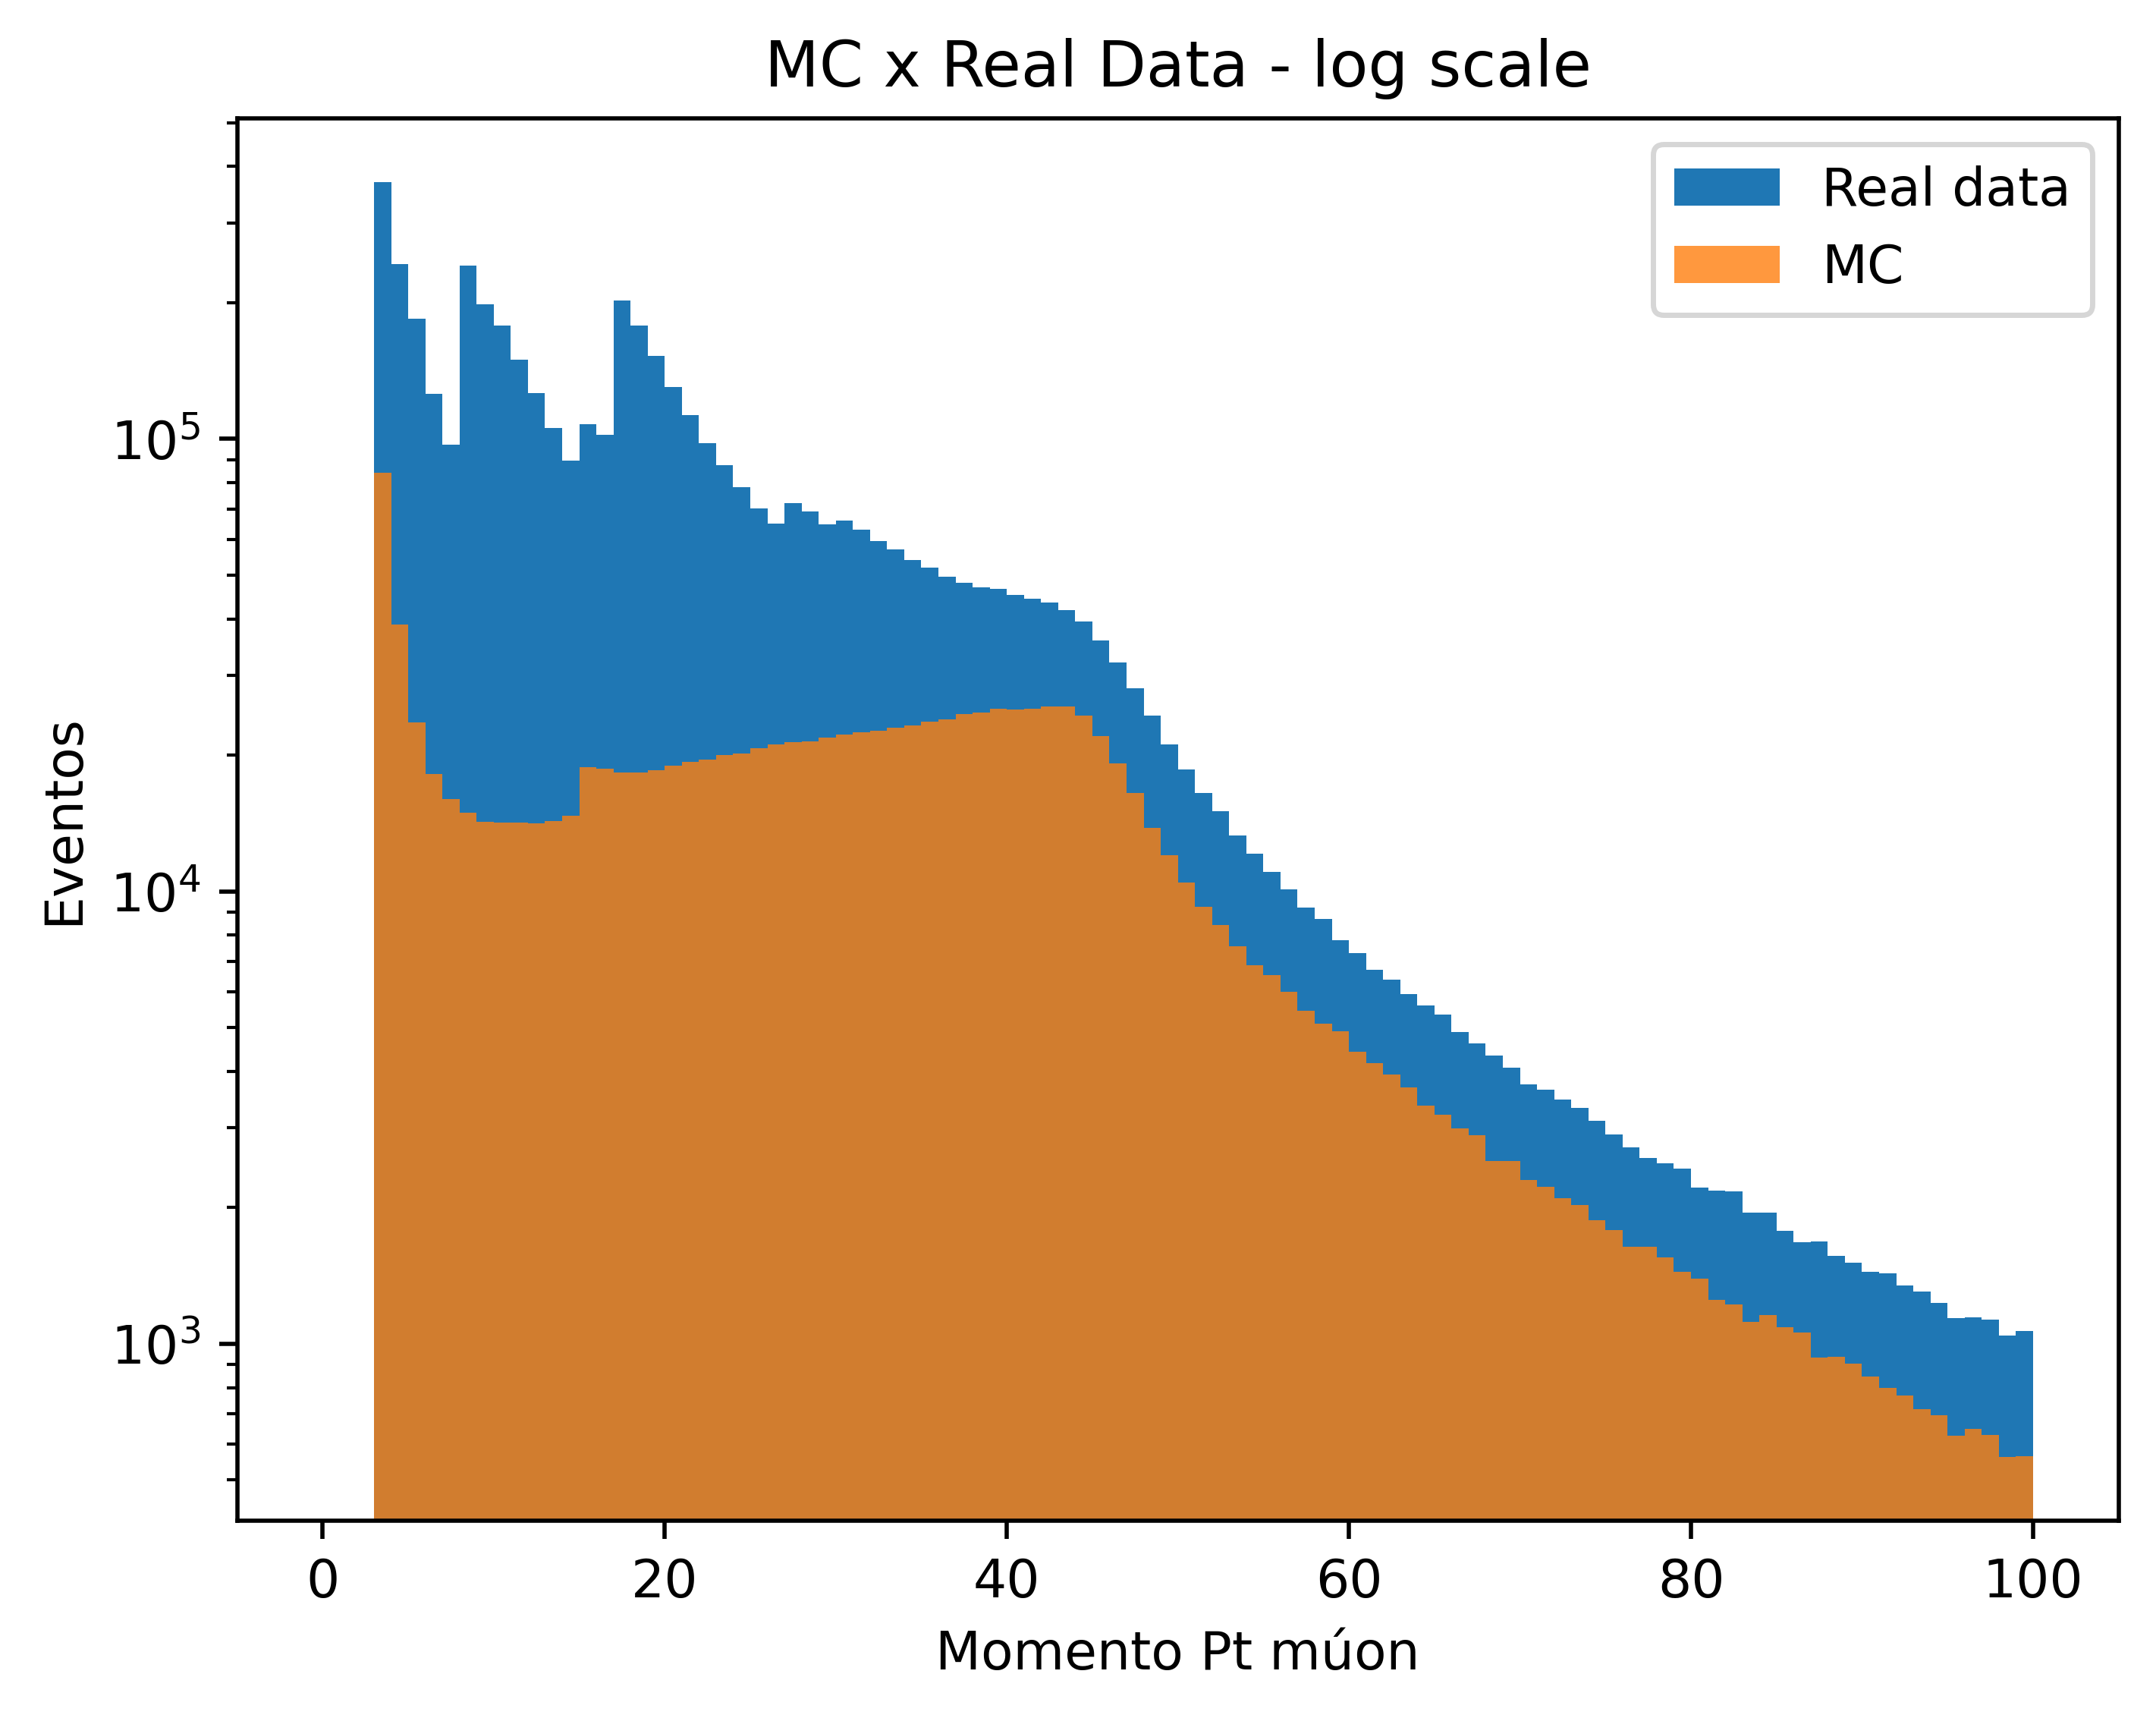

In [8]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="Real data")
hist_plot(vec, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

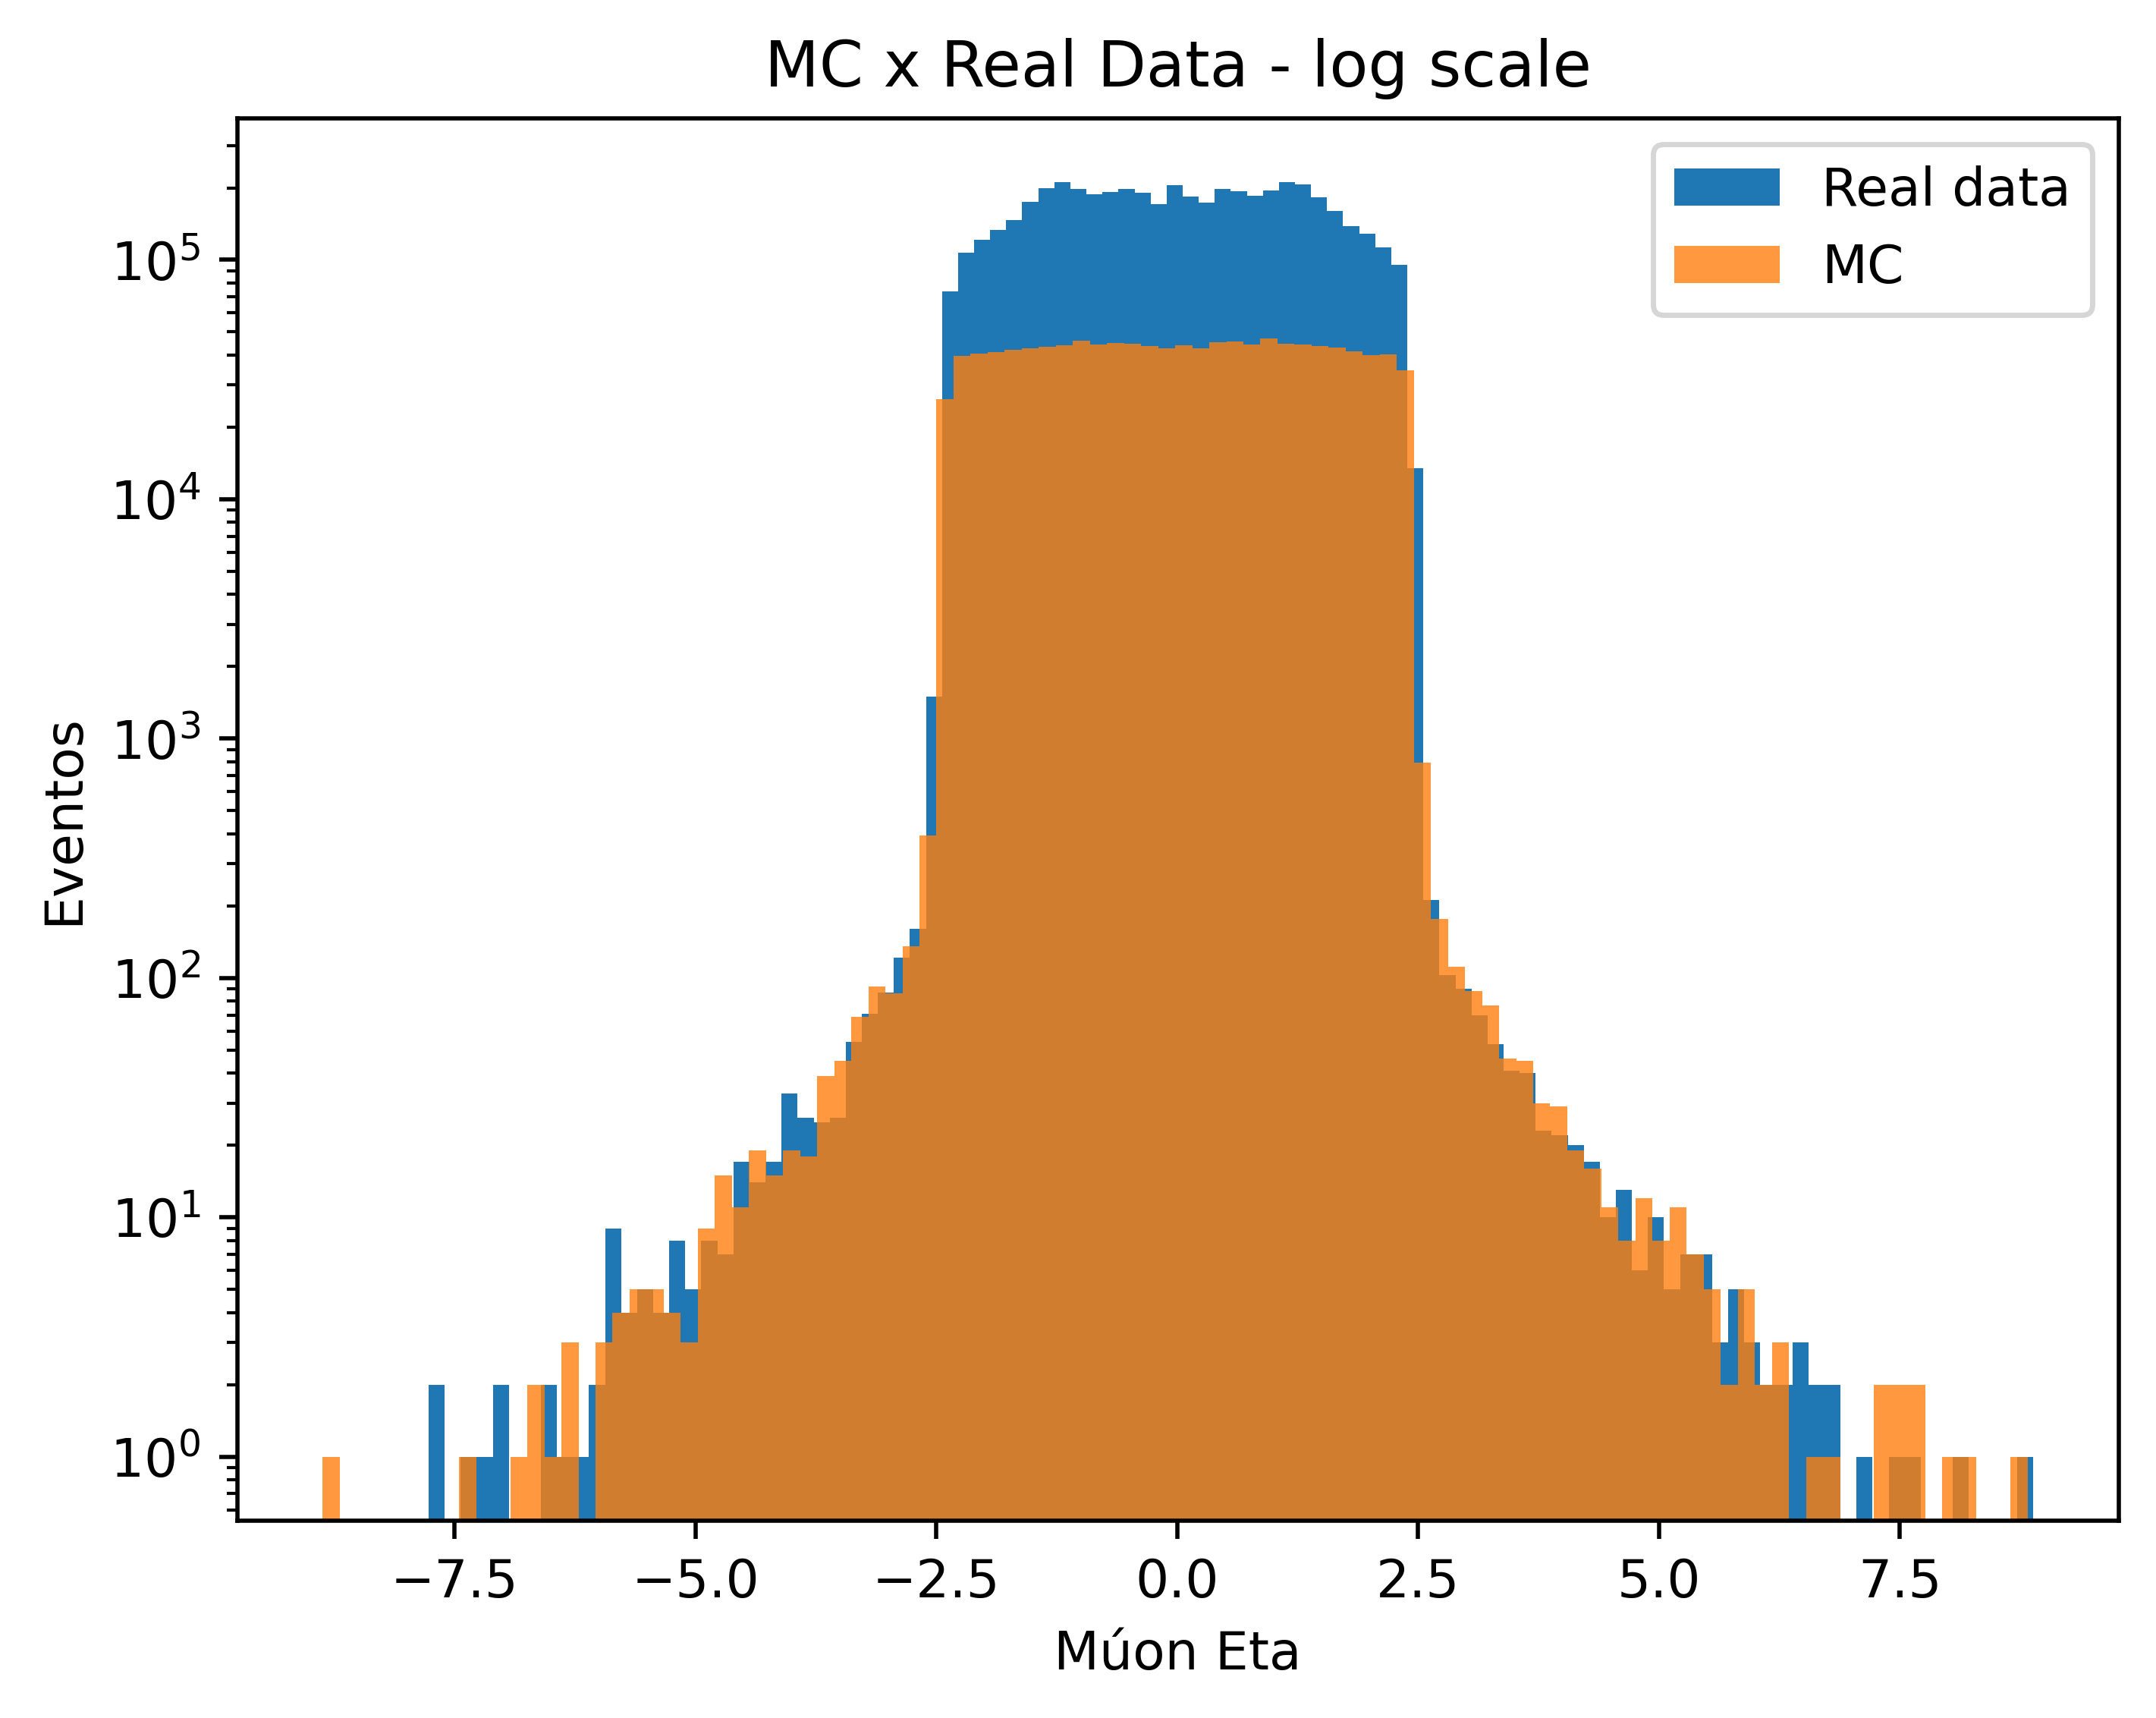

In [9]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "eta" , "Múon Eta", bins=100, log=True, label="Real data")
hist_plot(vec, "eta" , "Múon Eta", bins=100, log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

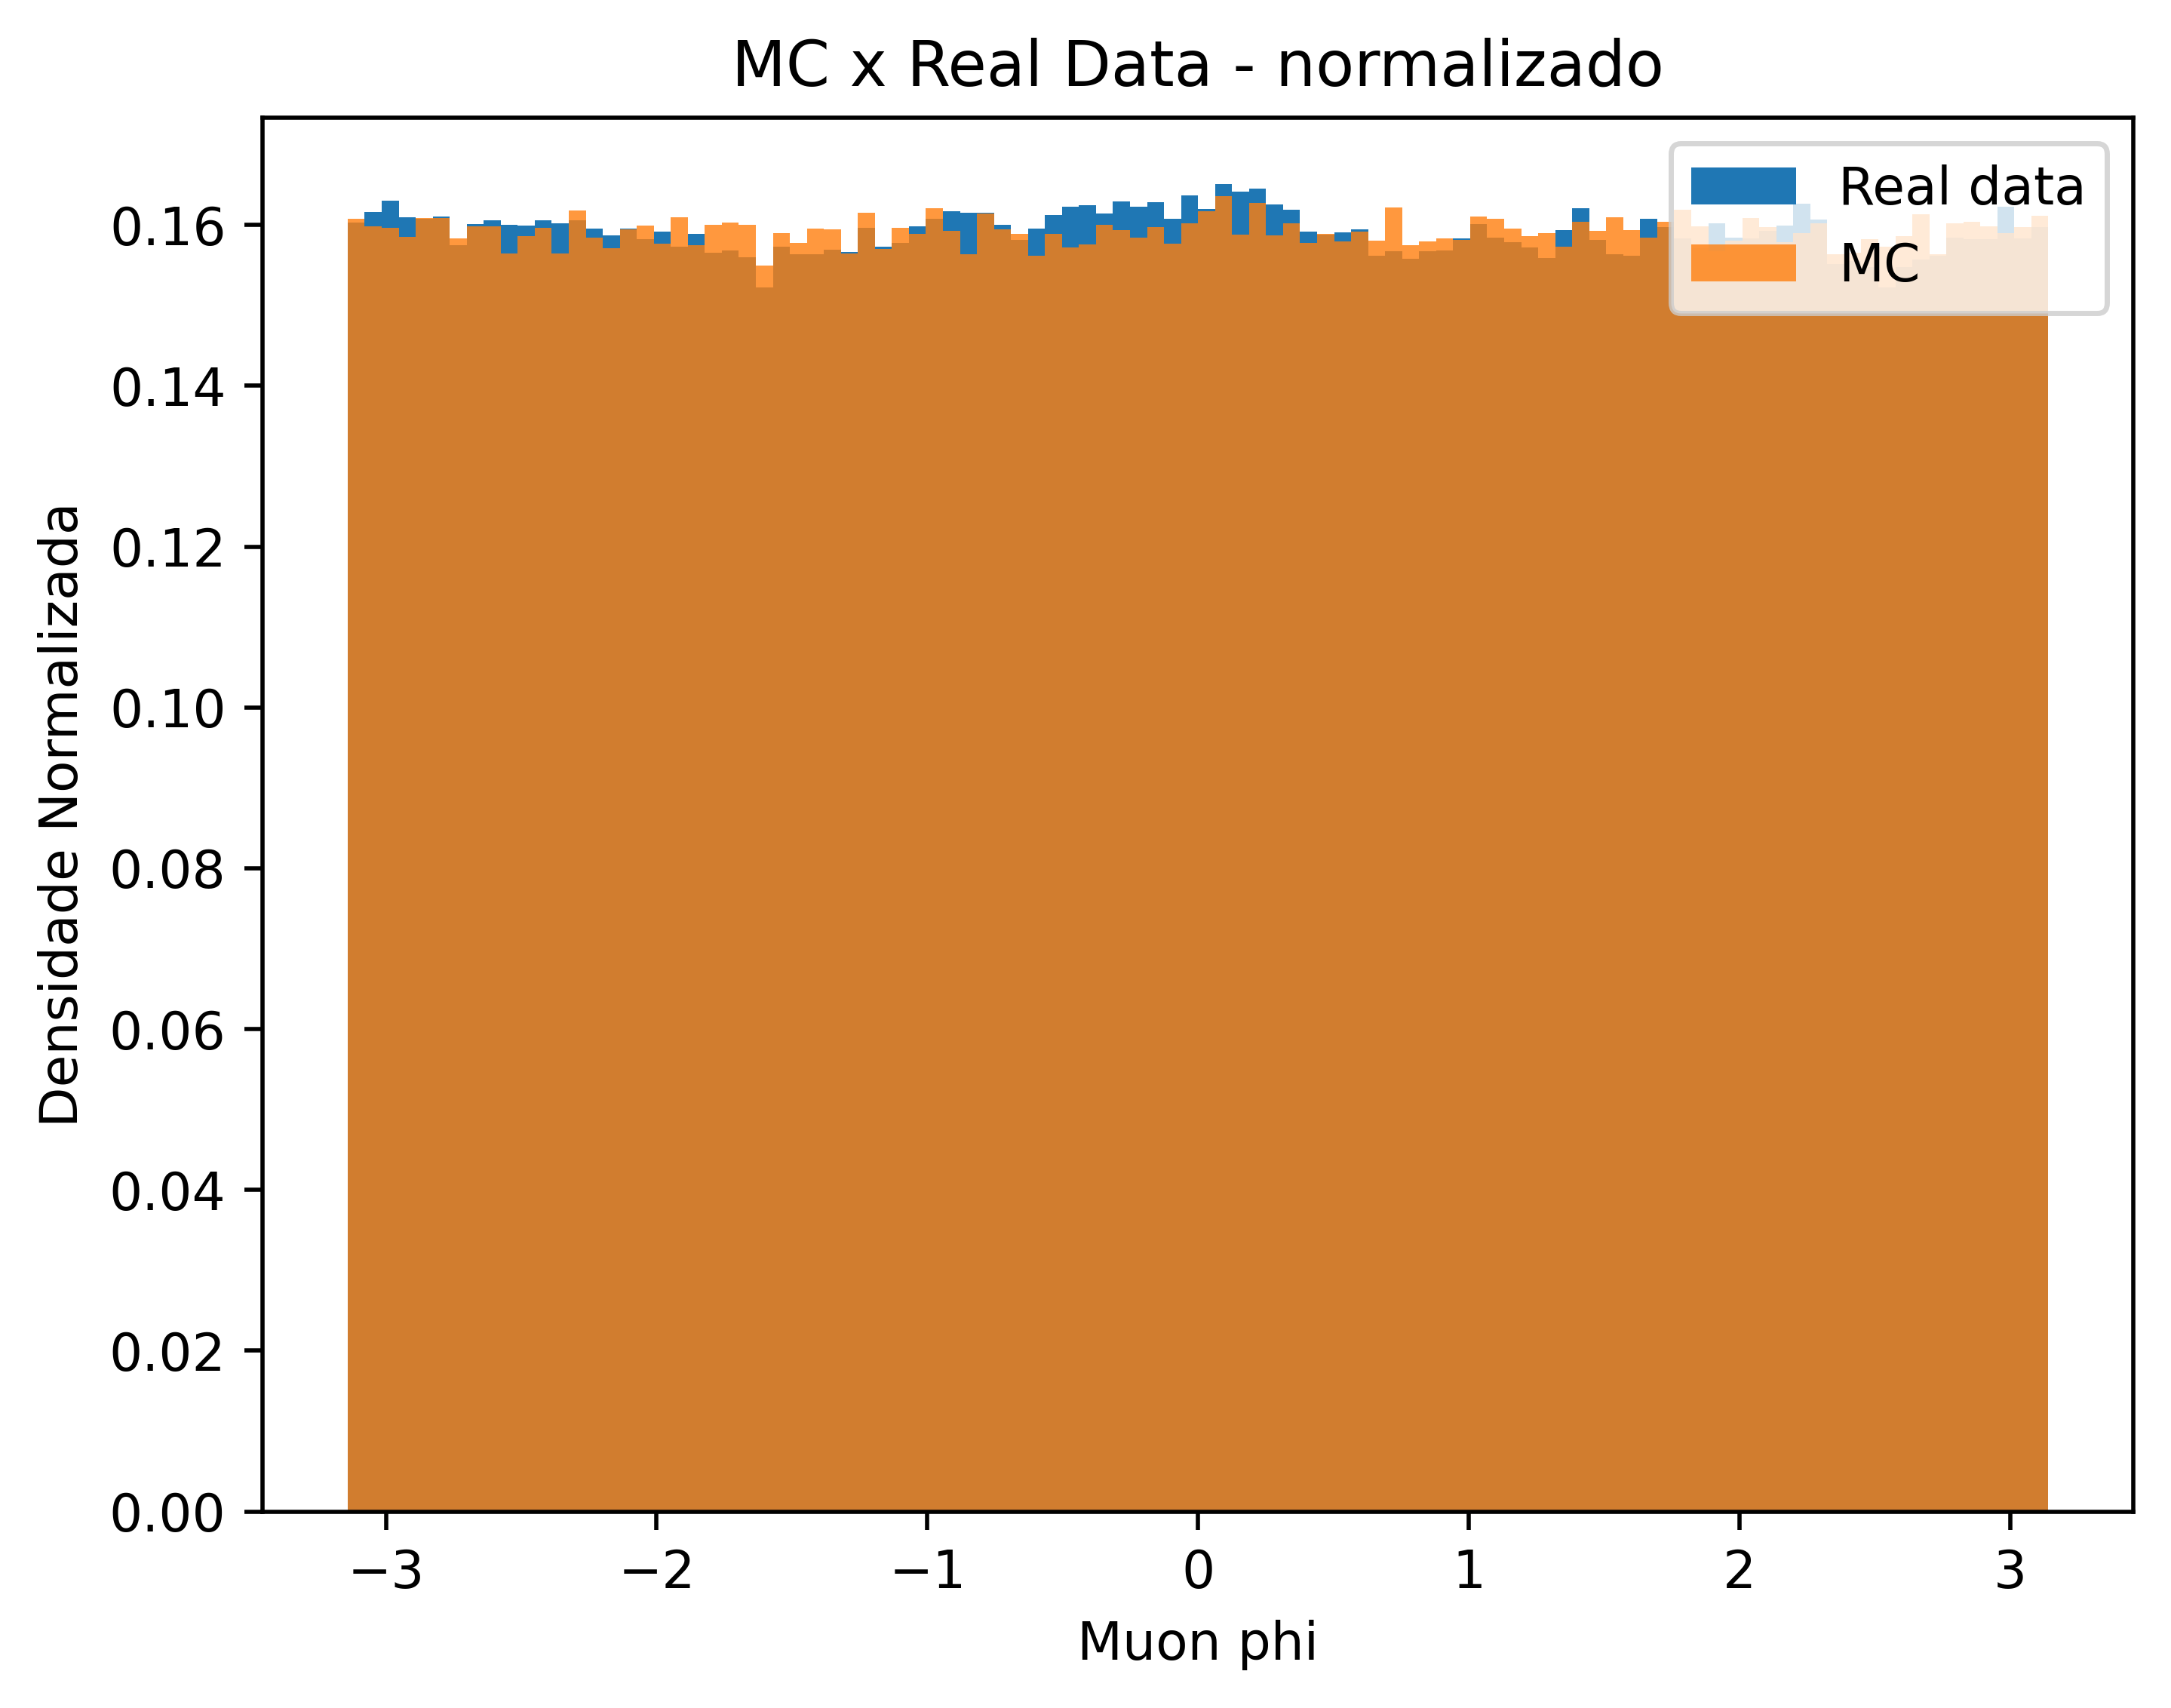

In [10]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "phi" , "Muon phi", bins=100, label="Real data", density=True)
hist_plot(vec, "phi" , "Muon phi", bins=100, label="MC", density=True, alpha=0.8)
plt.title("MC x Real Data - normalizado")
plt.ylabel("Densidade Normalizada")
plt.legend()
plt.show()

In [43]:
mass_real = inv_mass_expand(vec_real)
mass = inv_mass_expand(vec)

bin_centers, hist_counts = generate_points(mass_real)

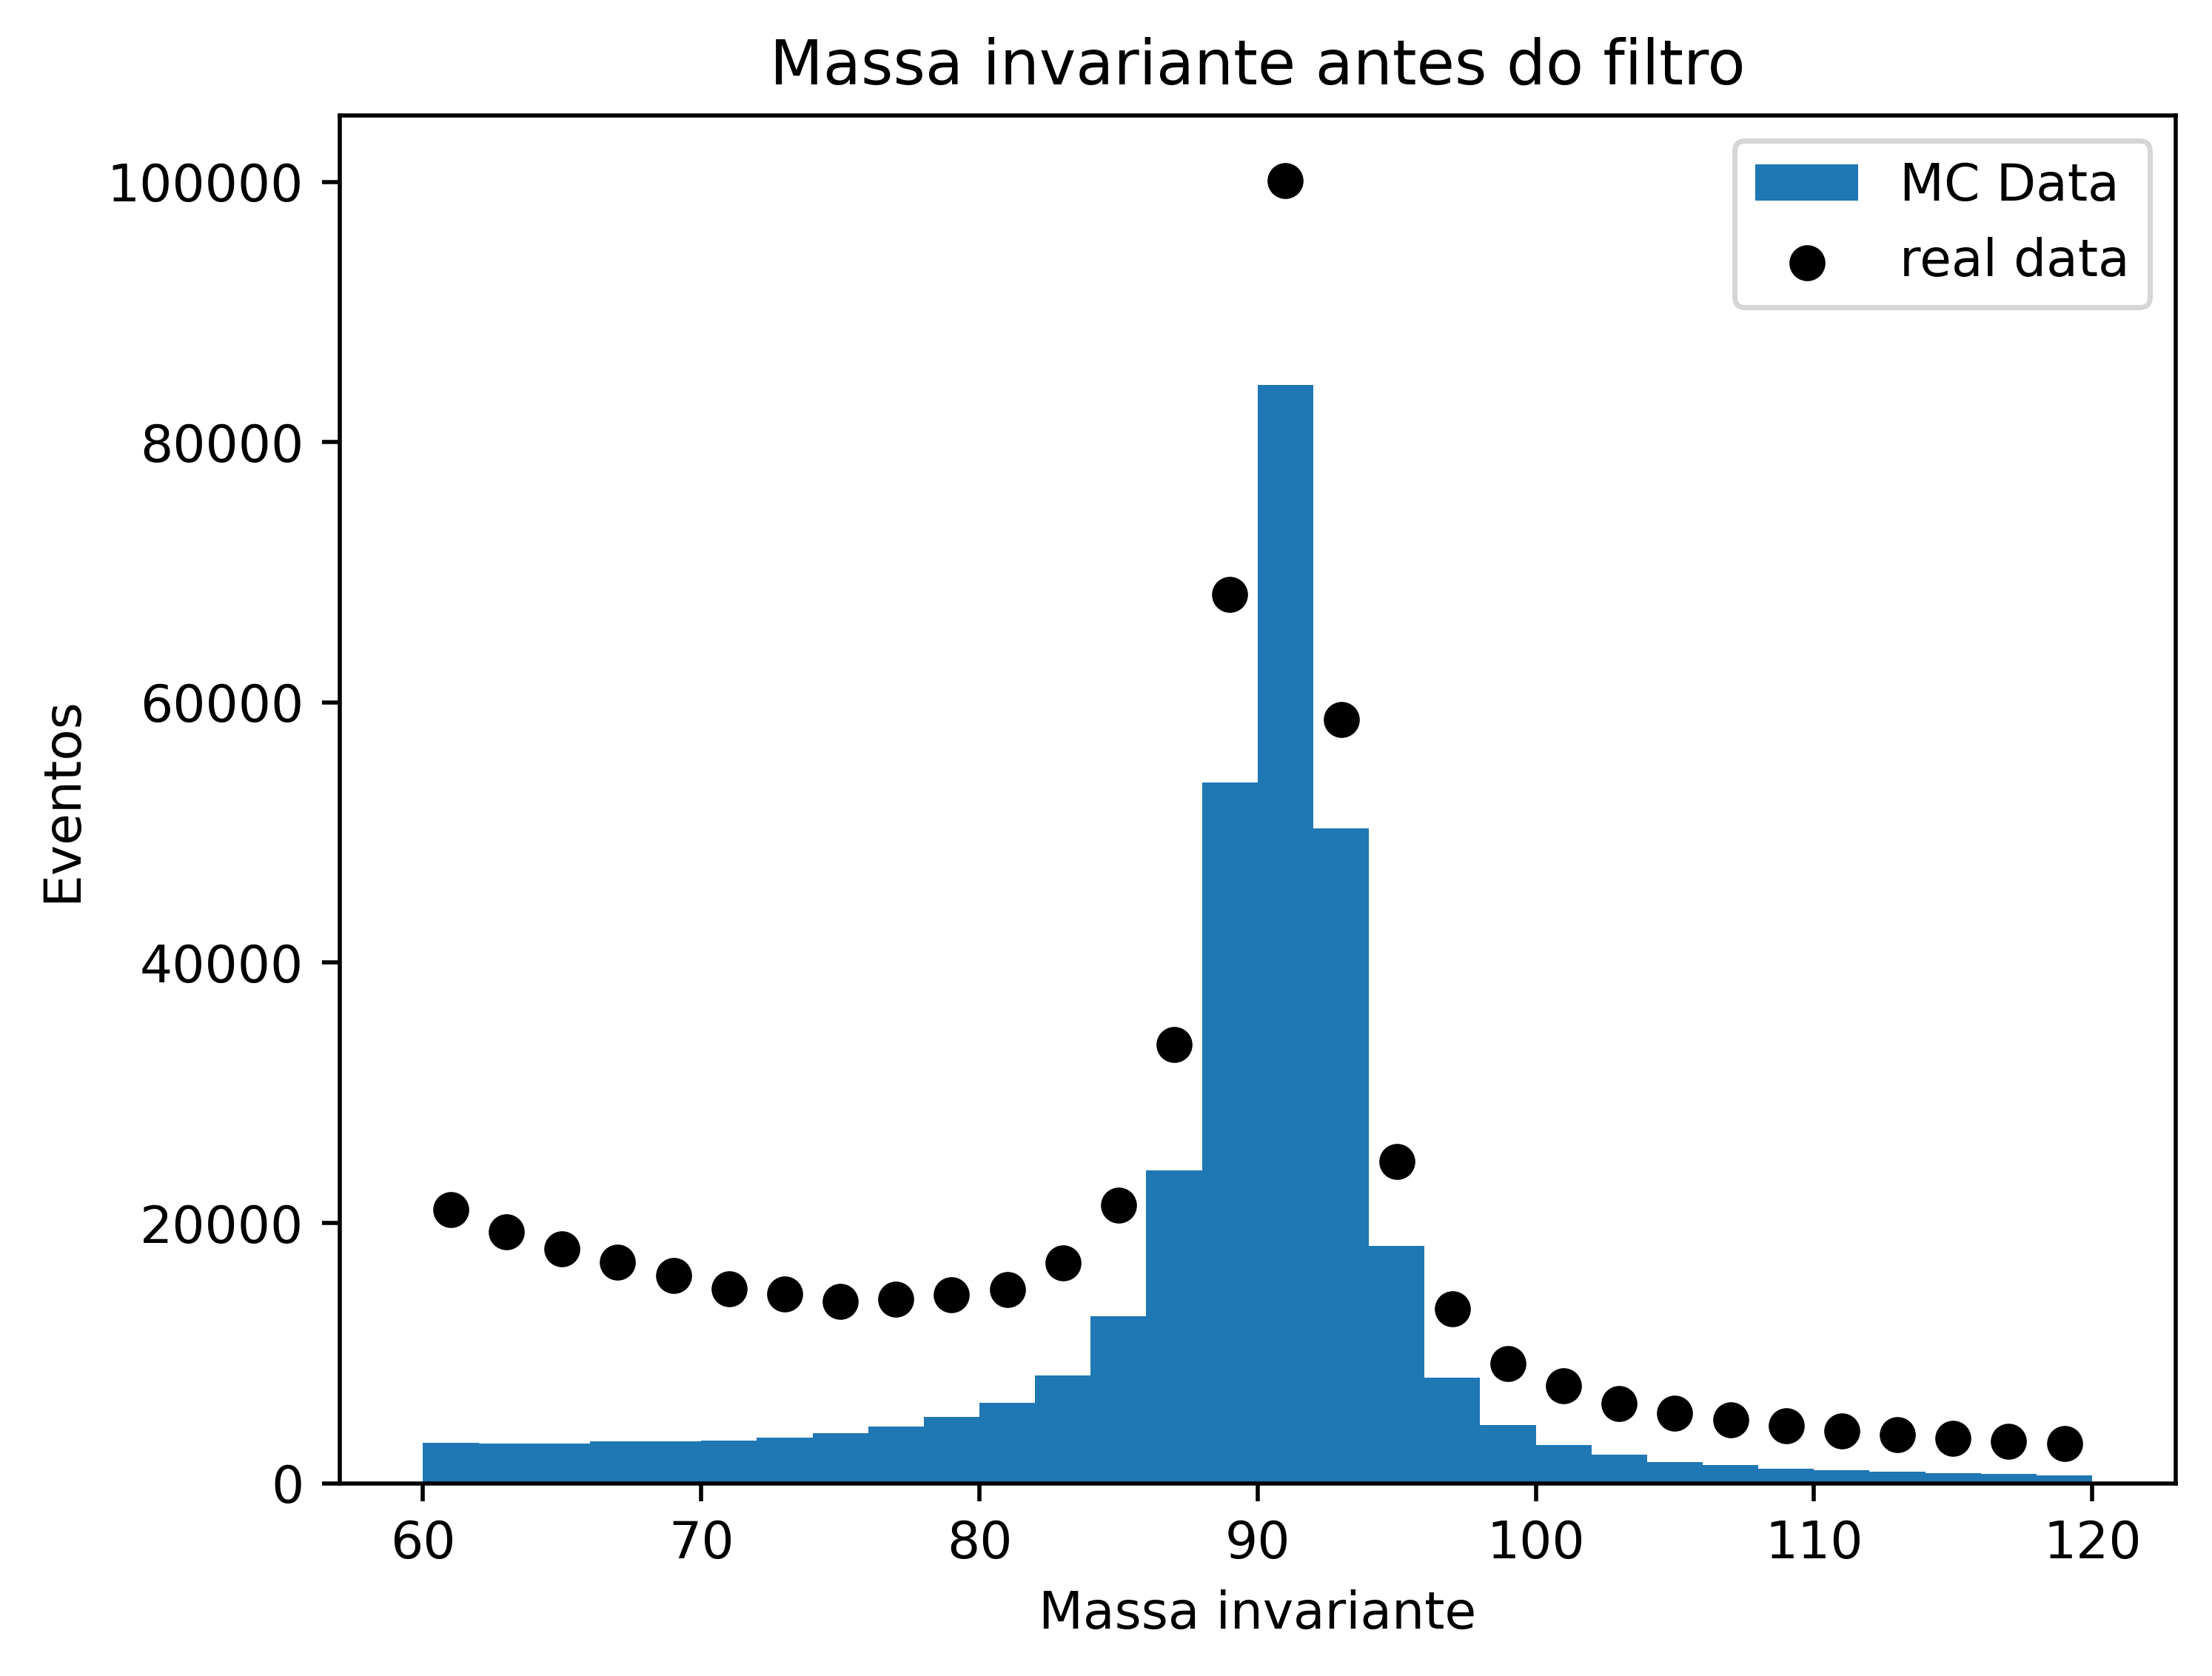

In [12]:
plt.figure(dpi=DPI)
plt.hist(mass, bins=BINS, label="MC Data")
plt.scatter(bin_centers, hist_counts, label="real data", color="black")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.title("Massa invariante antes do filtro")
plt.legend()
plt.show()

# Aplicando filtros

O evento que queremos estudar é:

Z -> mu+ mu-

Então:

In [59]:
# filtrando para garantir que vamos ter apenas 2 muons
filtered_real = vec_real[ak.num(vec_real) == 2]

# como só temos 2 muons, se somar a carga deles e der 0, significa que são de cargas opostas
filtered_real = filtered_real[ak.sum(filtered_real.charge, axis=1) == 0]

# filtrando para garantir que o pt seja maior que 20
filtered_real = filtered_real[filtered_real.pt> 20]

# fiiltros em relação aos dados
filtered_real = filtered_real[filtered_real.tkreliso < 4]
filtered_real = filtered_real[filtered_real.sip3d < 4]
filtered_real = filtered_real[filtered_real.eta < 2.1]
filtered_real = filtered_real[filtered_real.eta > -2.1]


# realizando o mesmo processo para os dados simulados
filtered = vec[ak.num(vec) == 2]
filtered = filtered[ak.sum(filtered.charge, axis=1) == 0]
filtered = filtered[filtered.pt> 20] # filtered = filtered[ak.all(filtered.pt> 20, axis=1)] ??
filtered = filtered[filtered.tkreliso < 4]
filtered = filtered[filtered.sip3d < 4]
filtered = filtered[filtered.eta < 2.1]
filtered = filtered[filtered.eta > -2.1]

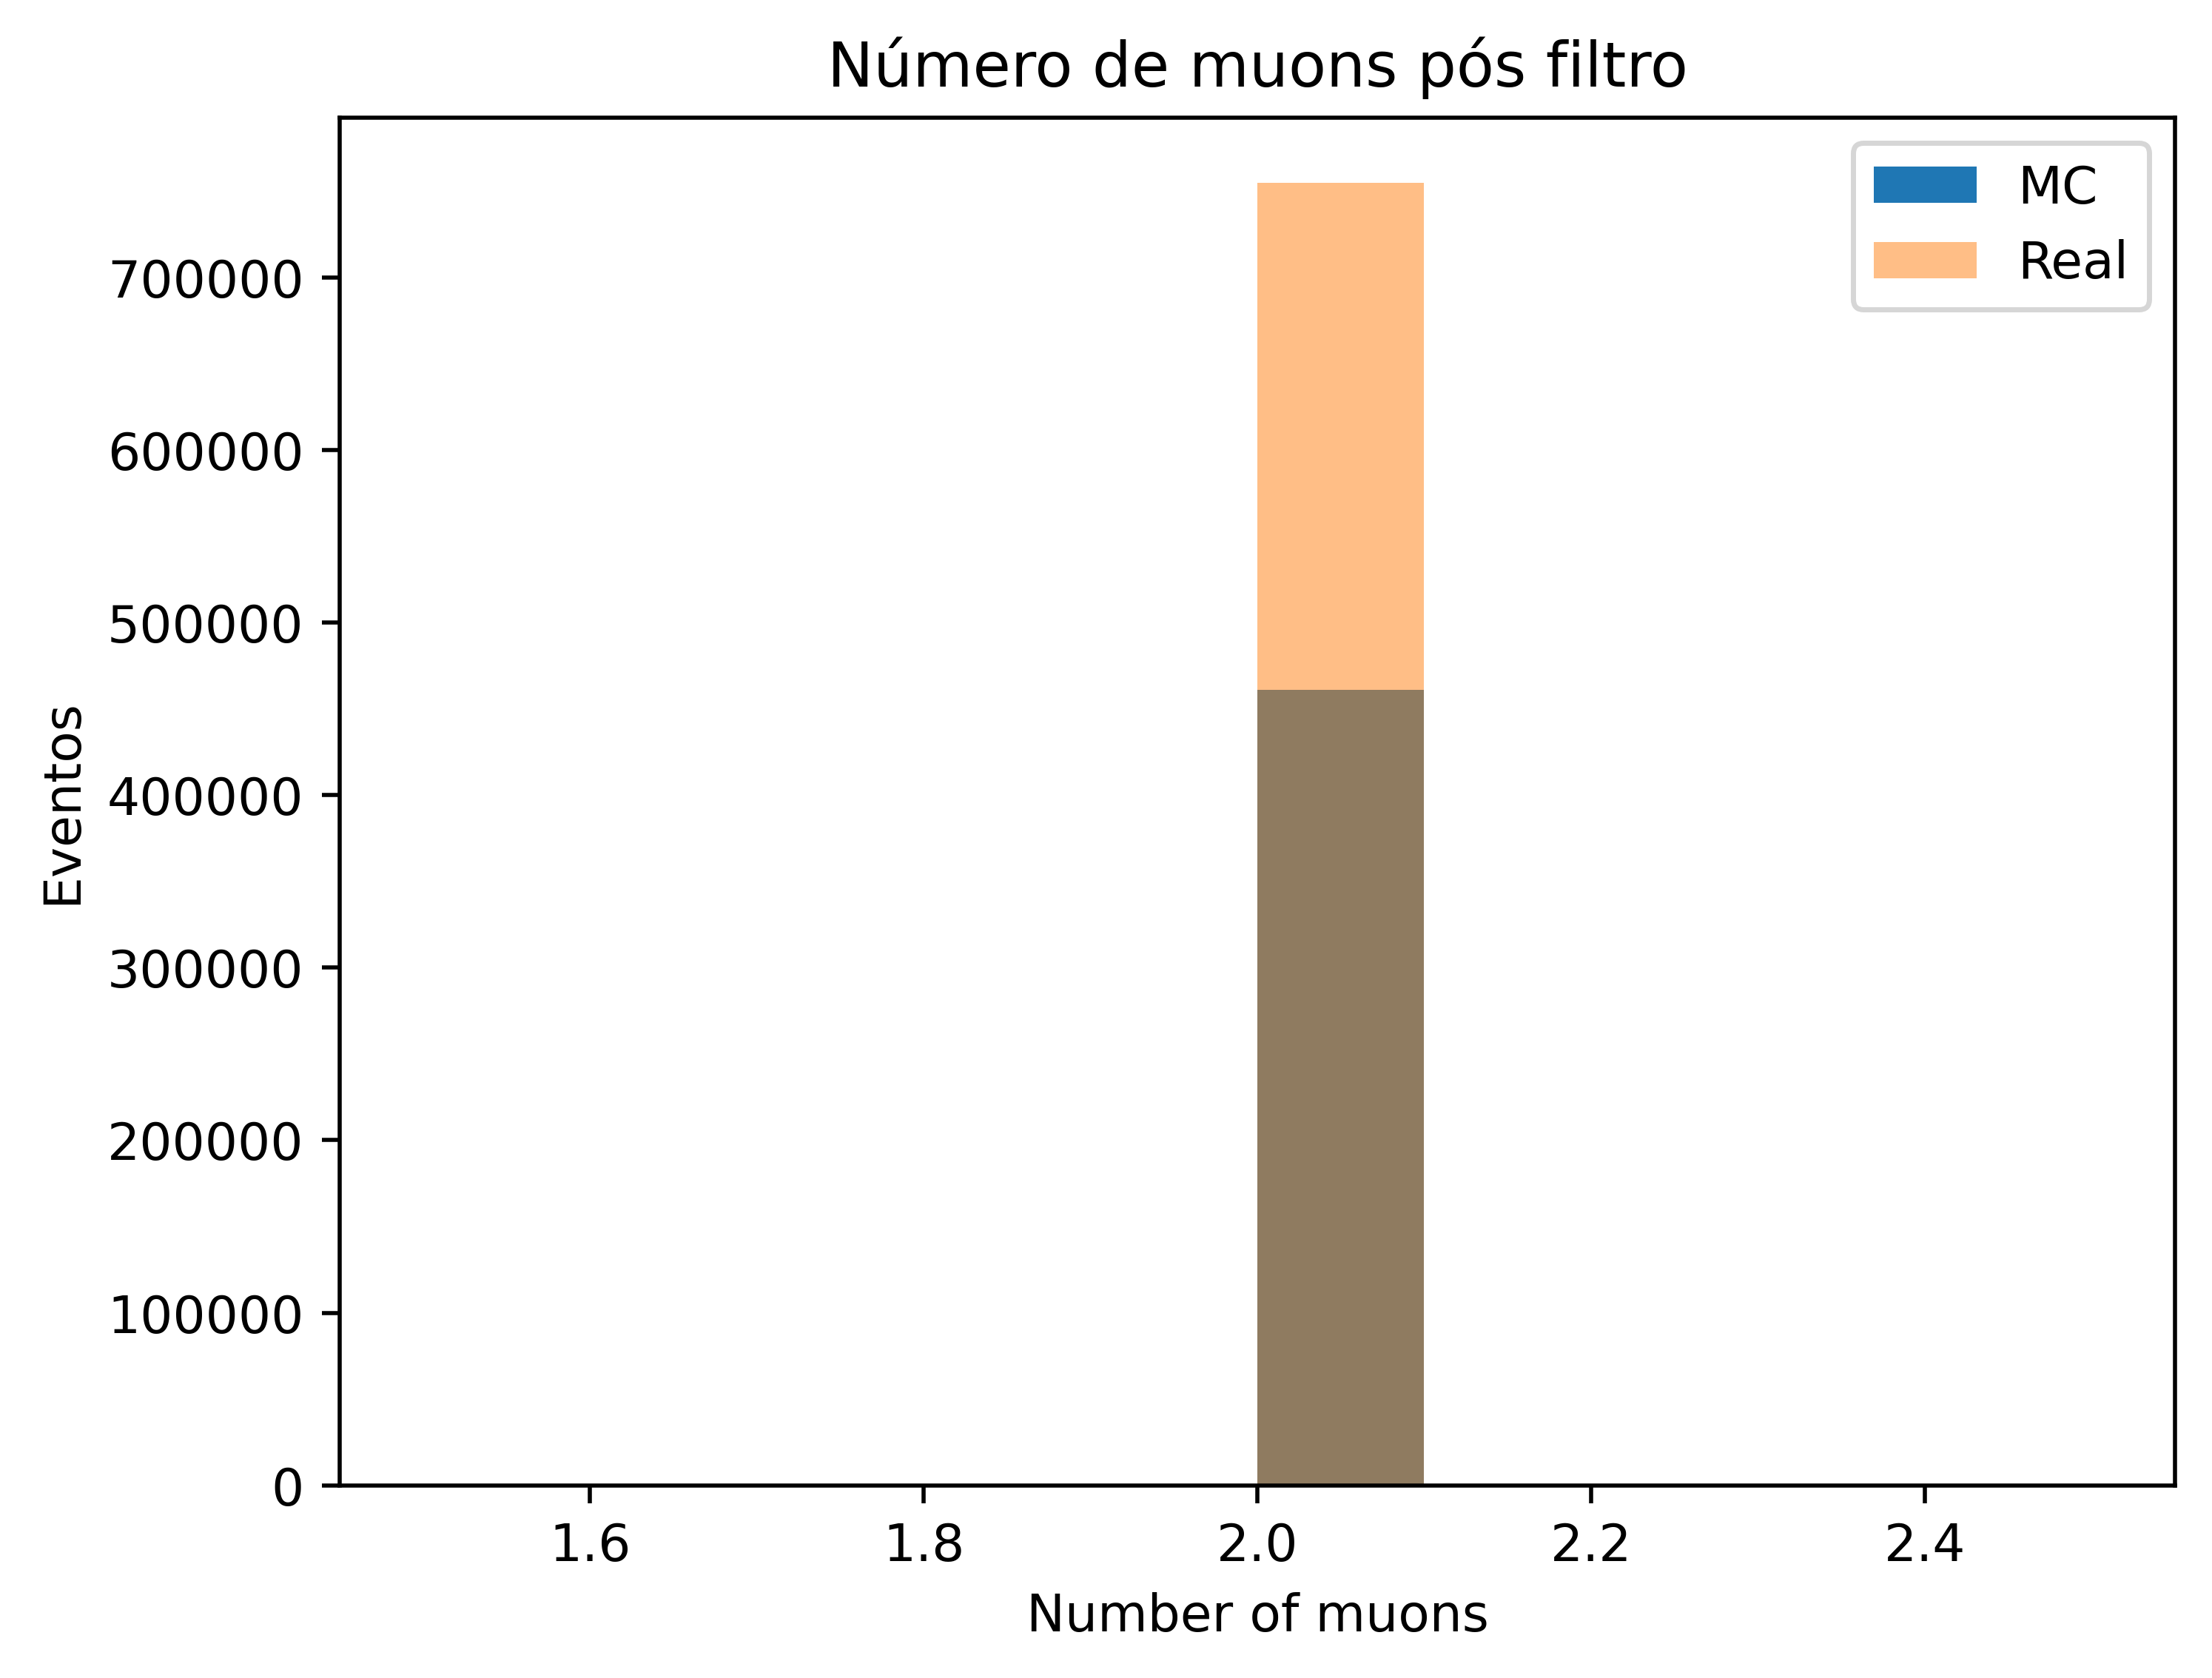

In [60]:
plt.figure(dpi=DPI)
hist_plot(filtered, "nmuon", "Number of muons", label="MC")
hist_plot(filtered_real, "nmuon", "Number of muons", label="Real", alpha=0.5)
plt.title("Número de muons pós filtro")
plt.legend()
plt.show()

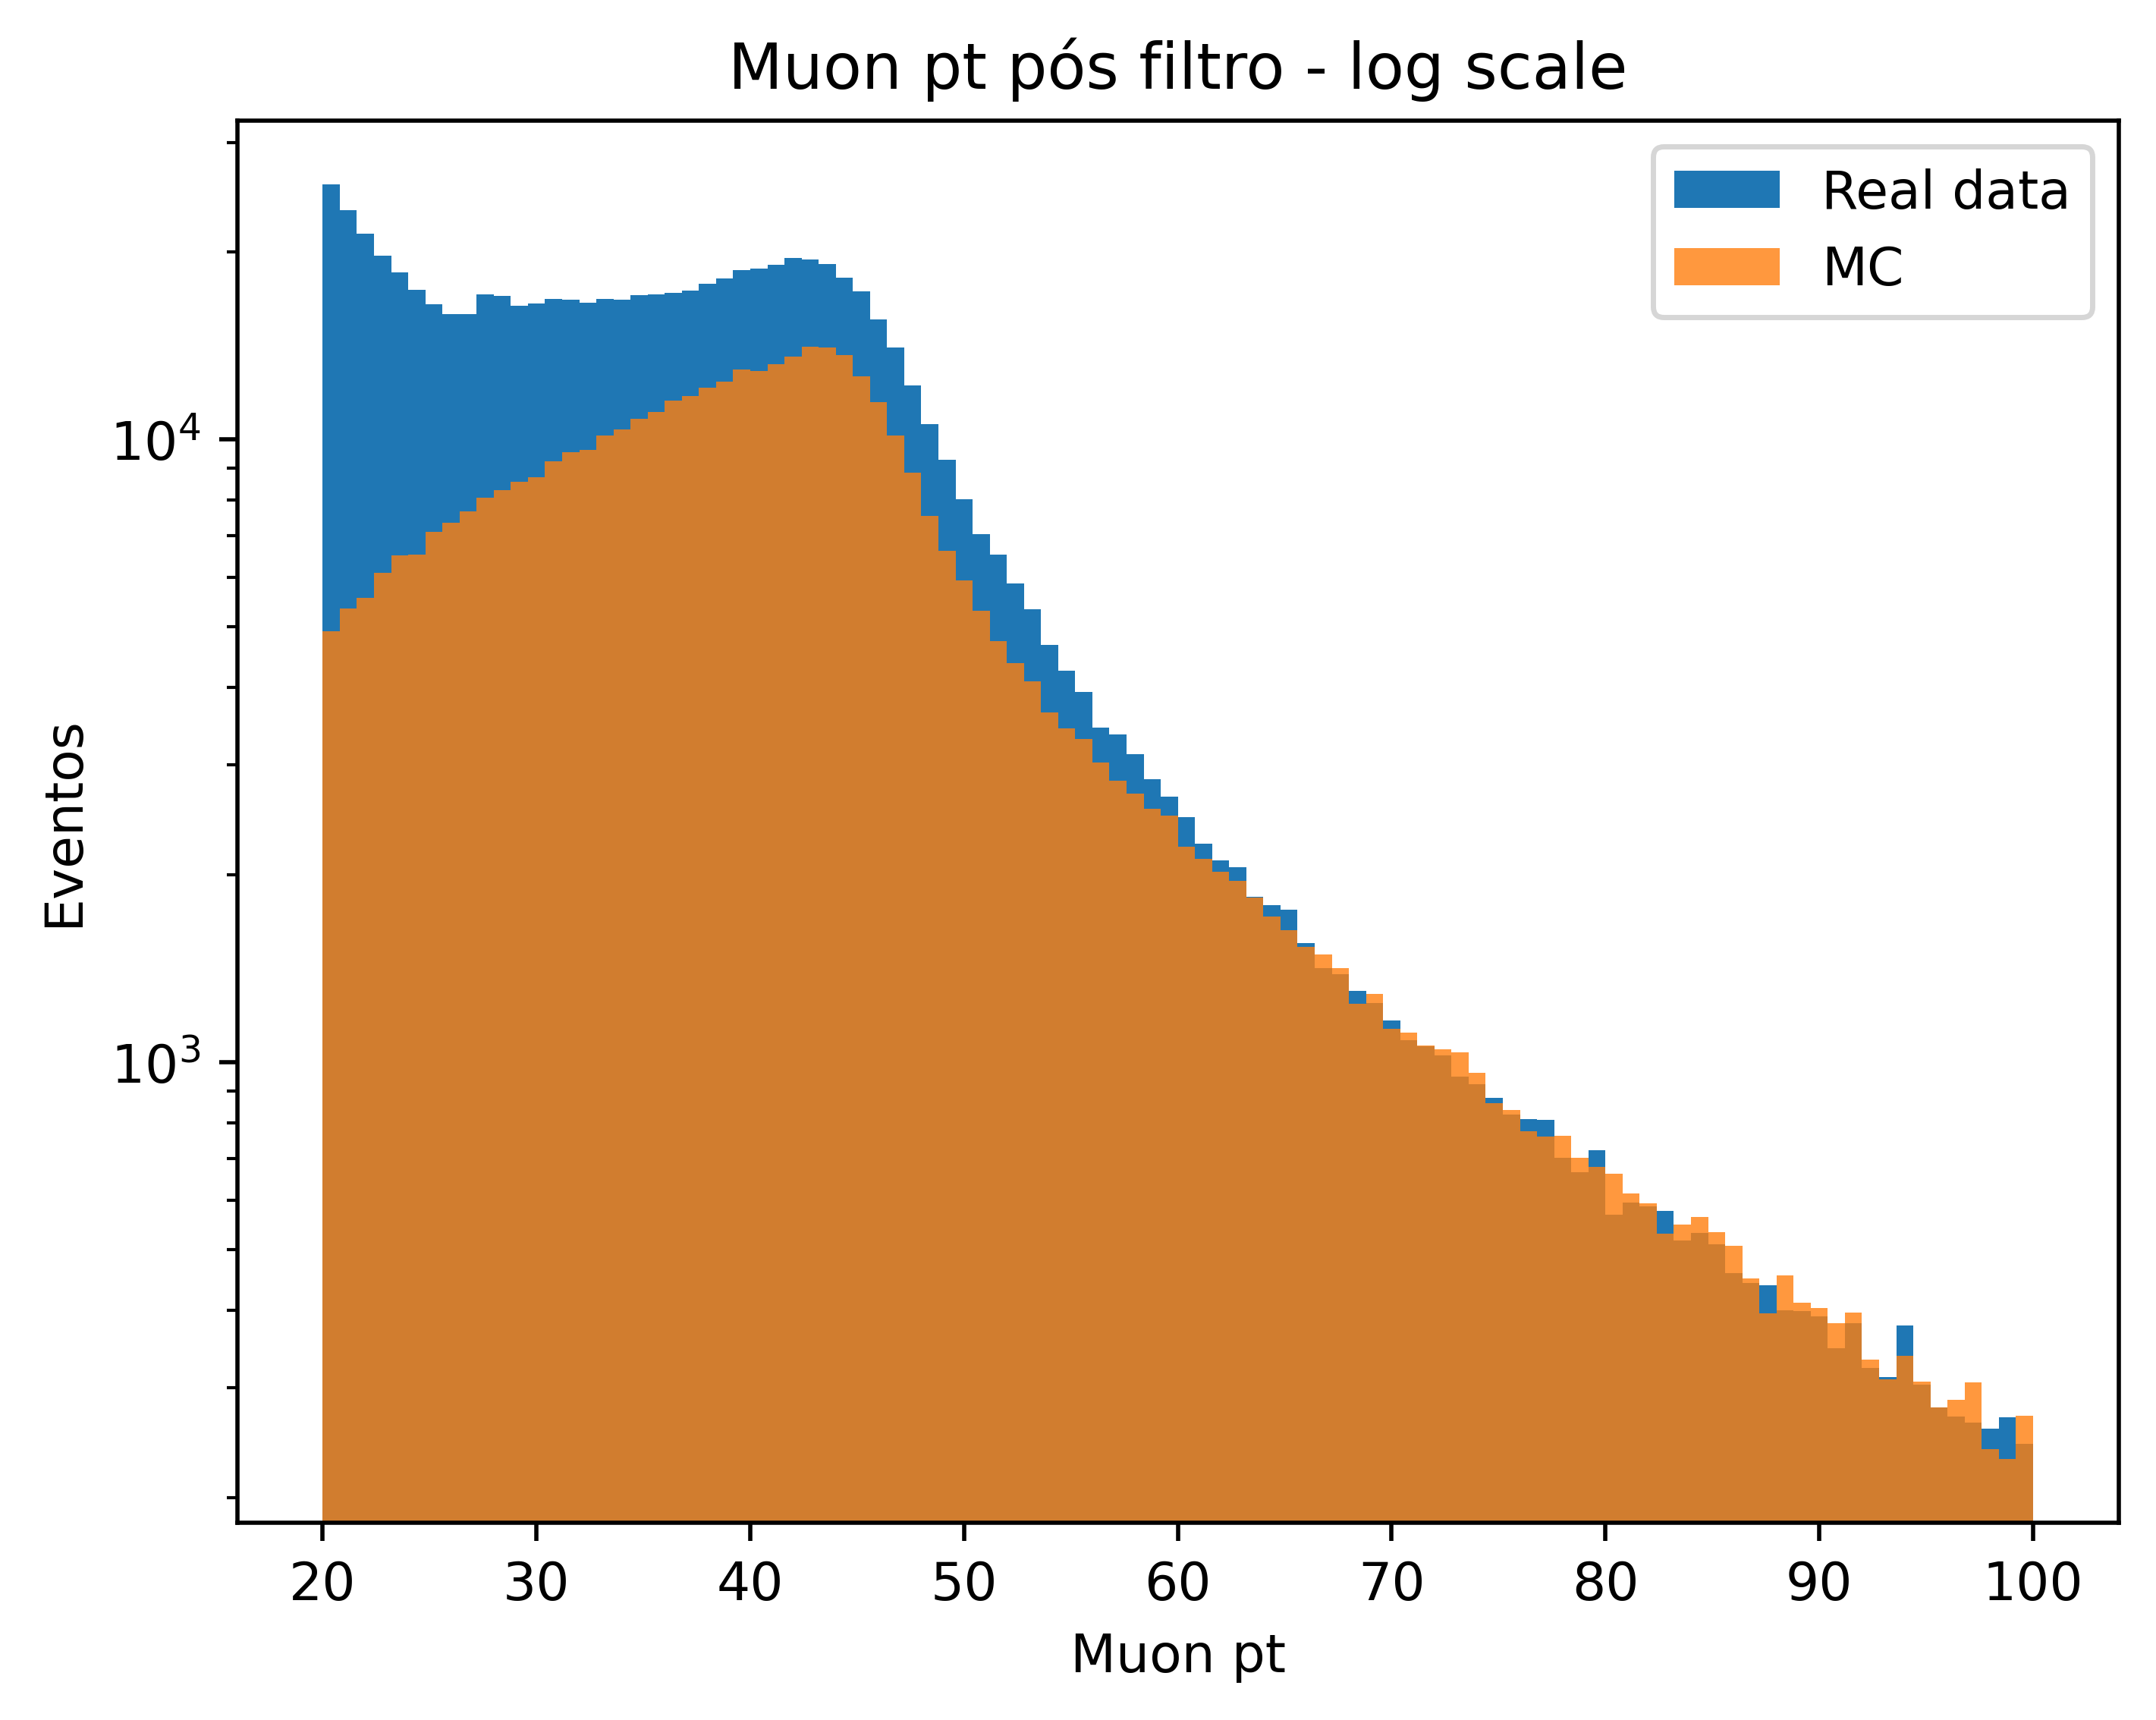

In [61]:
plt.figure(dpi=DPI)
hist_plot(filtered_real, "pt" , "Muon pt", bins=100, range=(20, 100), log=True, label="Real data")
hist_plot(filtered, "pt" , "Muon pt", bins=100, range=(20, 100), log=True, label="MC", alpha=0.8)
plt.title("Muon pt pós filtro - log scale")
plt.legend()
plt.show()

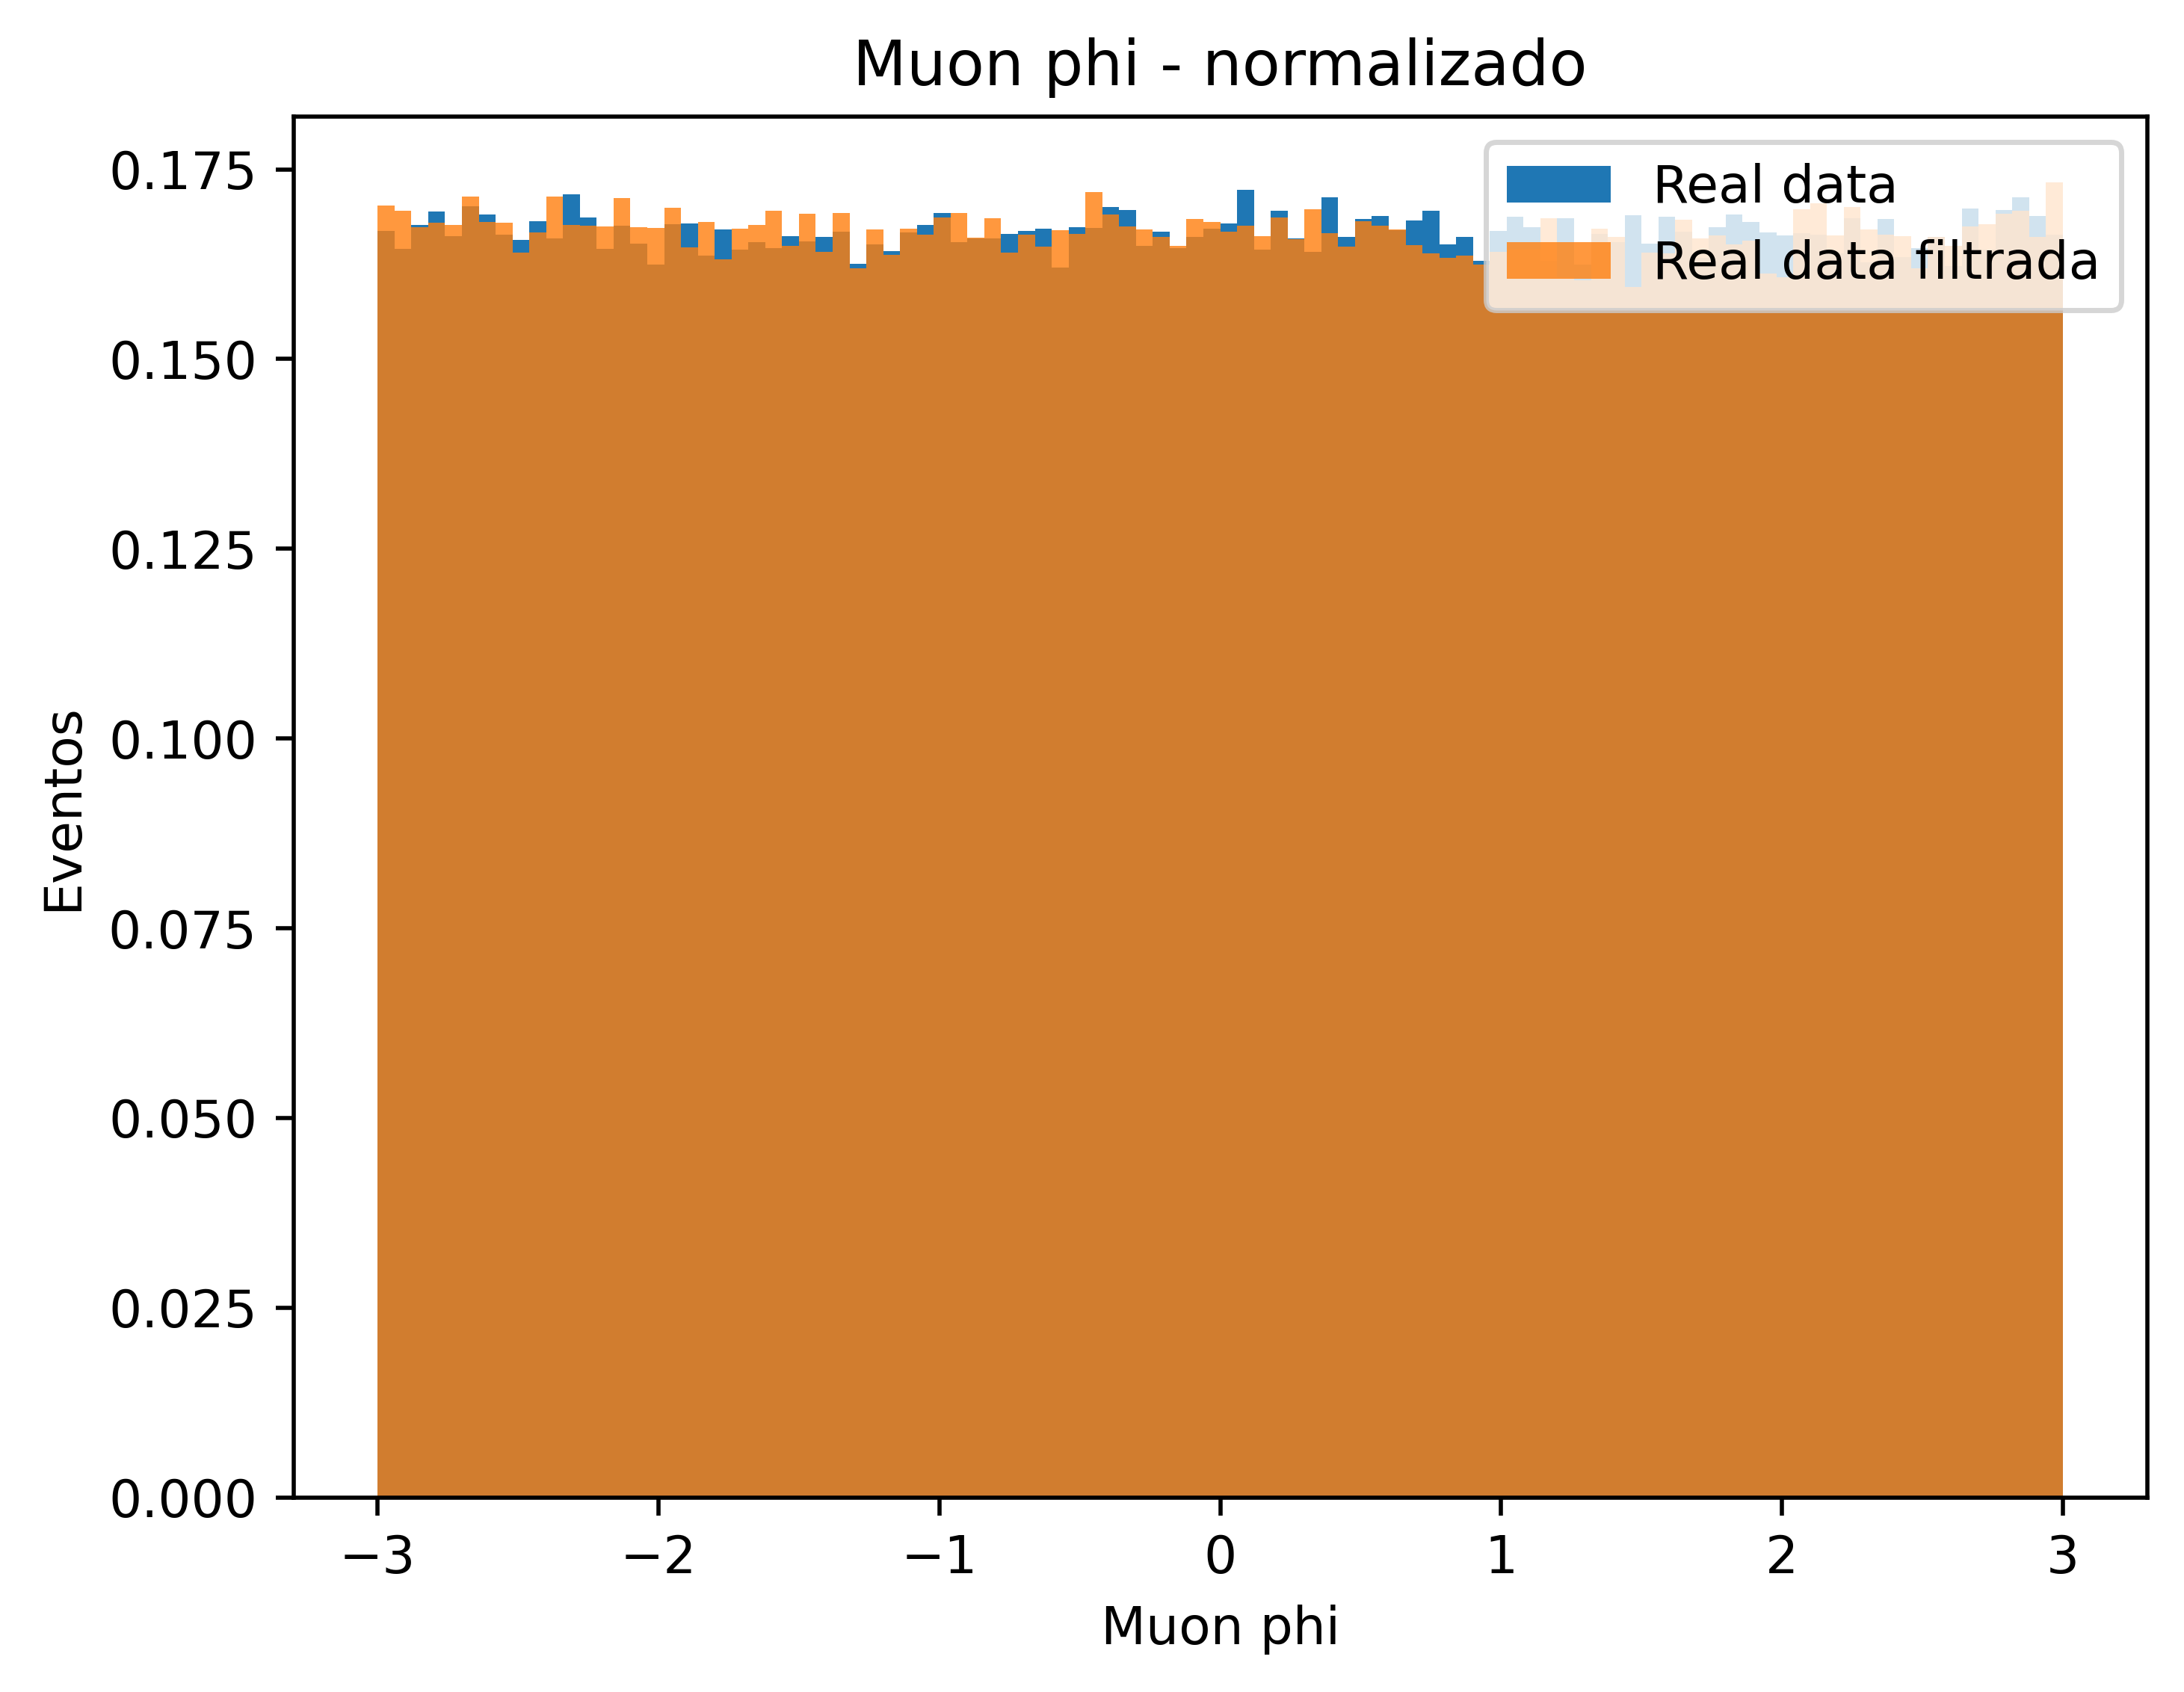

In [62]:
plt.figure(dpi=DPI)
hist_plot(filtered, "phi", "Muon phi", bins=100, range=(-3, 3), label="Real data", density=True)
hist_plot(filtered_real, "phi", "Muon phi", bins=100, range=(-3, 3), label="Real data filtrada", density=True, alpha=0.8)
plt.title("Muon phi - normalizado")
plt.legend()
plt.show()

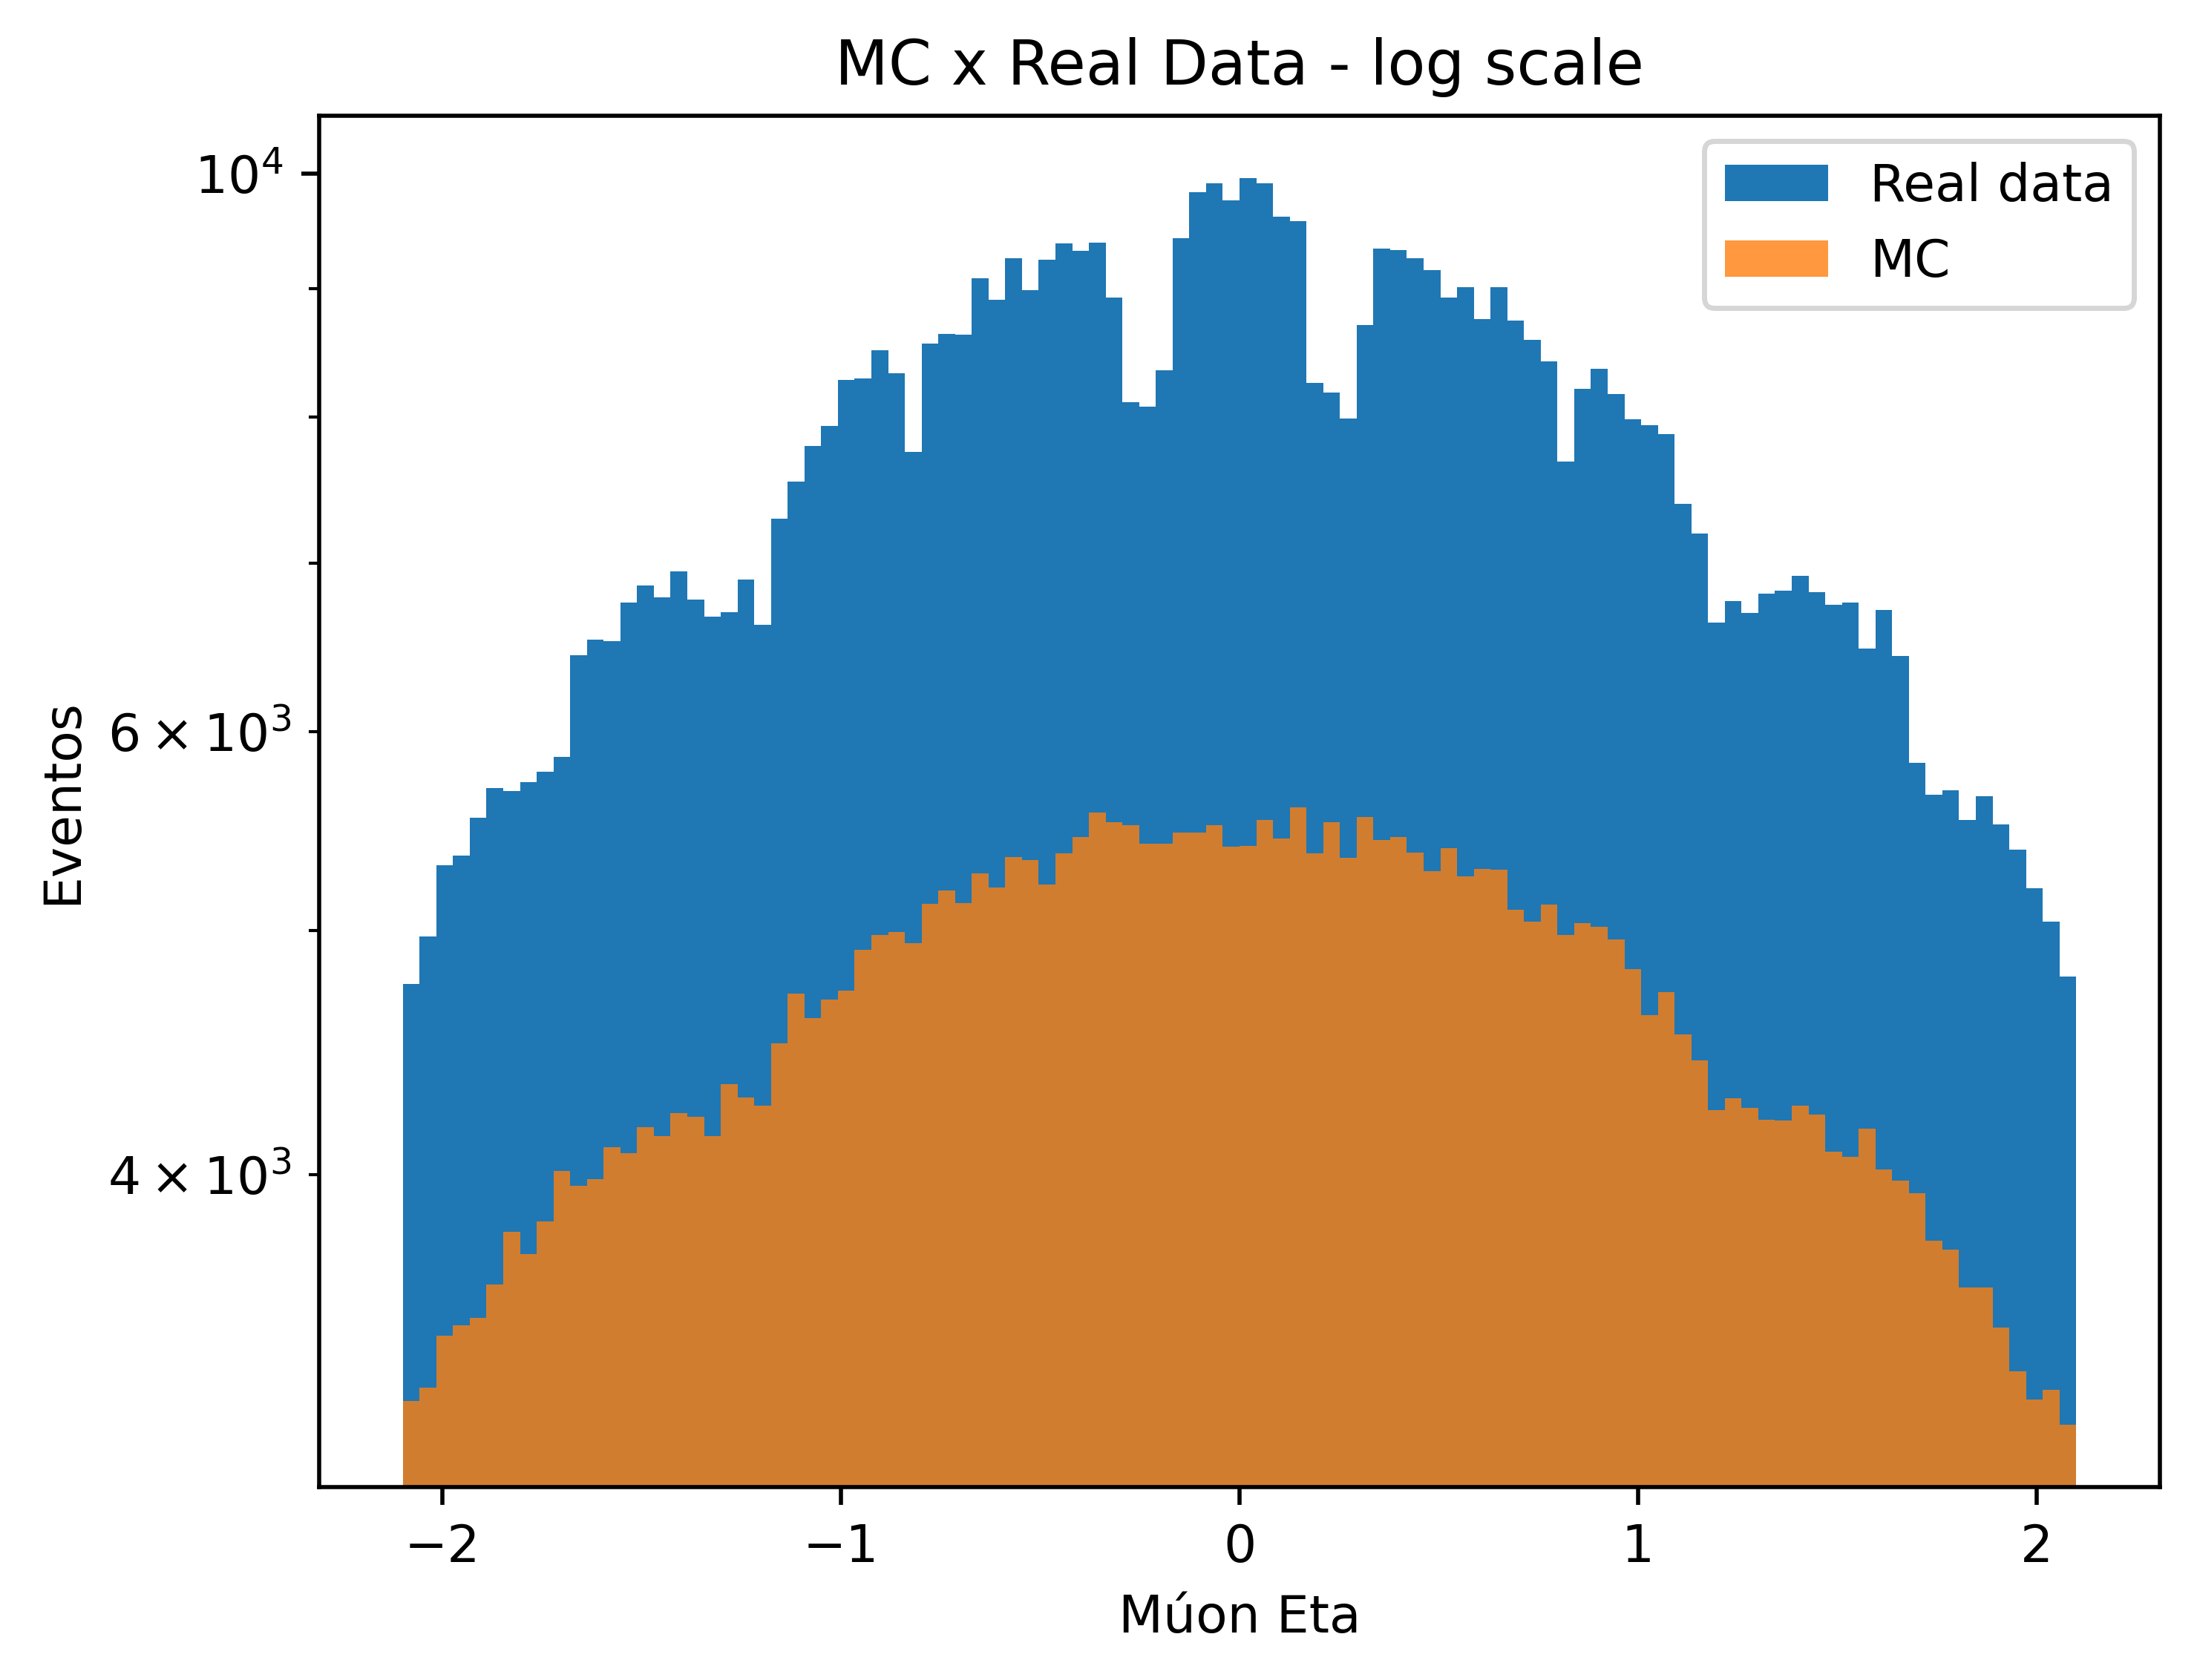

In [64]:
plt.figure(dpi=DPI)
hist_plot(filtered_real, "eta" , "Múon Eta", bins=100, log=True, label="Real data")
hist_plot(filtered, "eta" , "Múon Eta", bins=100, log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data - log scale")
plt.legend()
plt.show()

In [65]:
mass_real_filtered = inv_mass_expand(filtered_real)
mass_filtered = inv_mass_expand(filtered)

bin_centers_filtered, hist_counts_filtered = generate_points(mass_real_filtered)


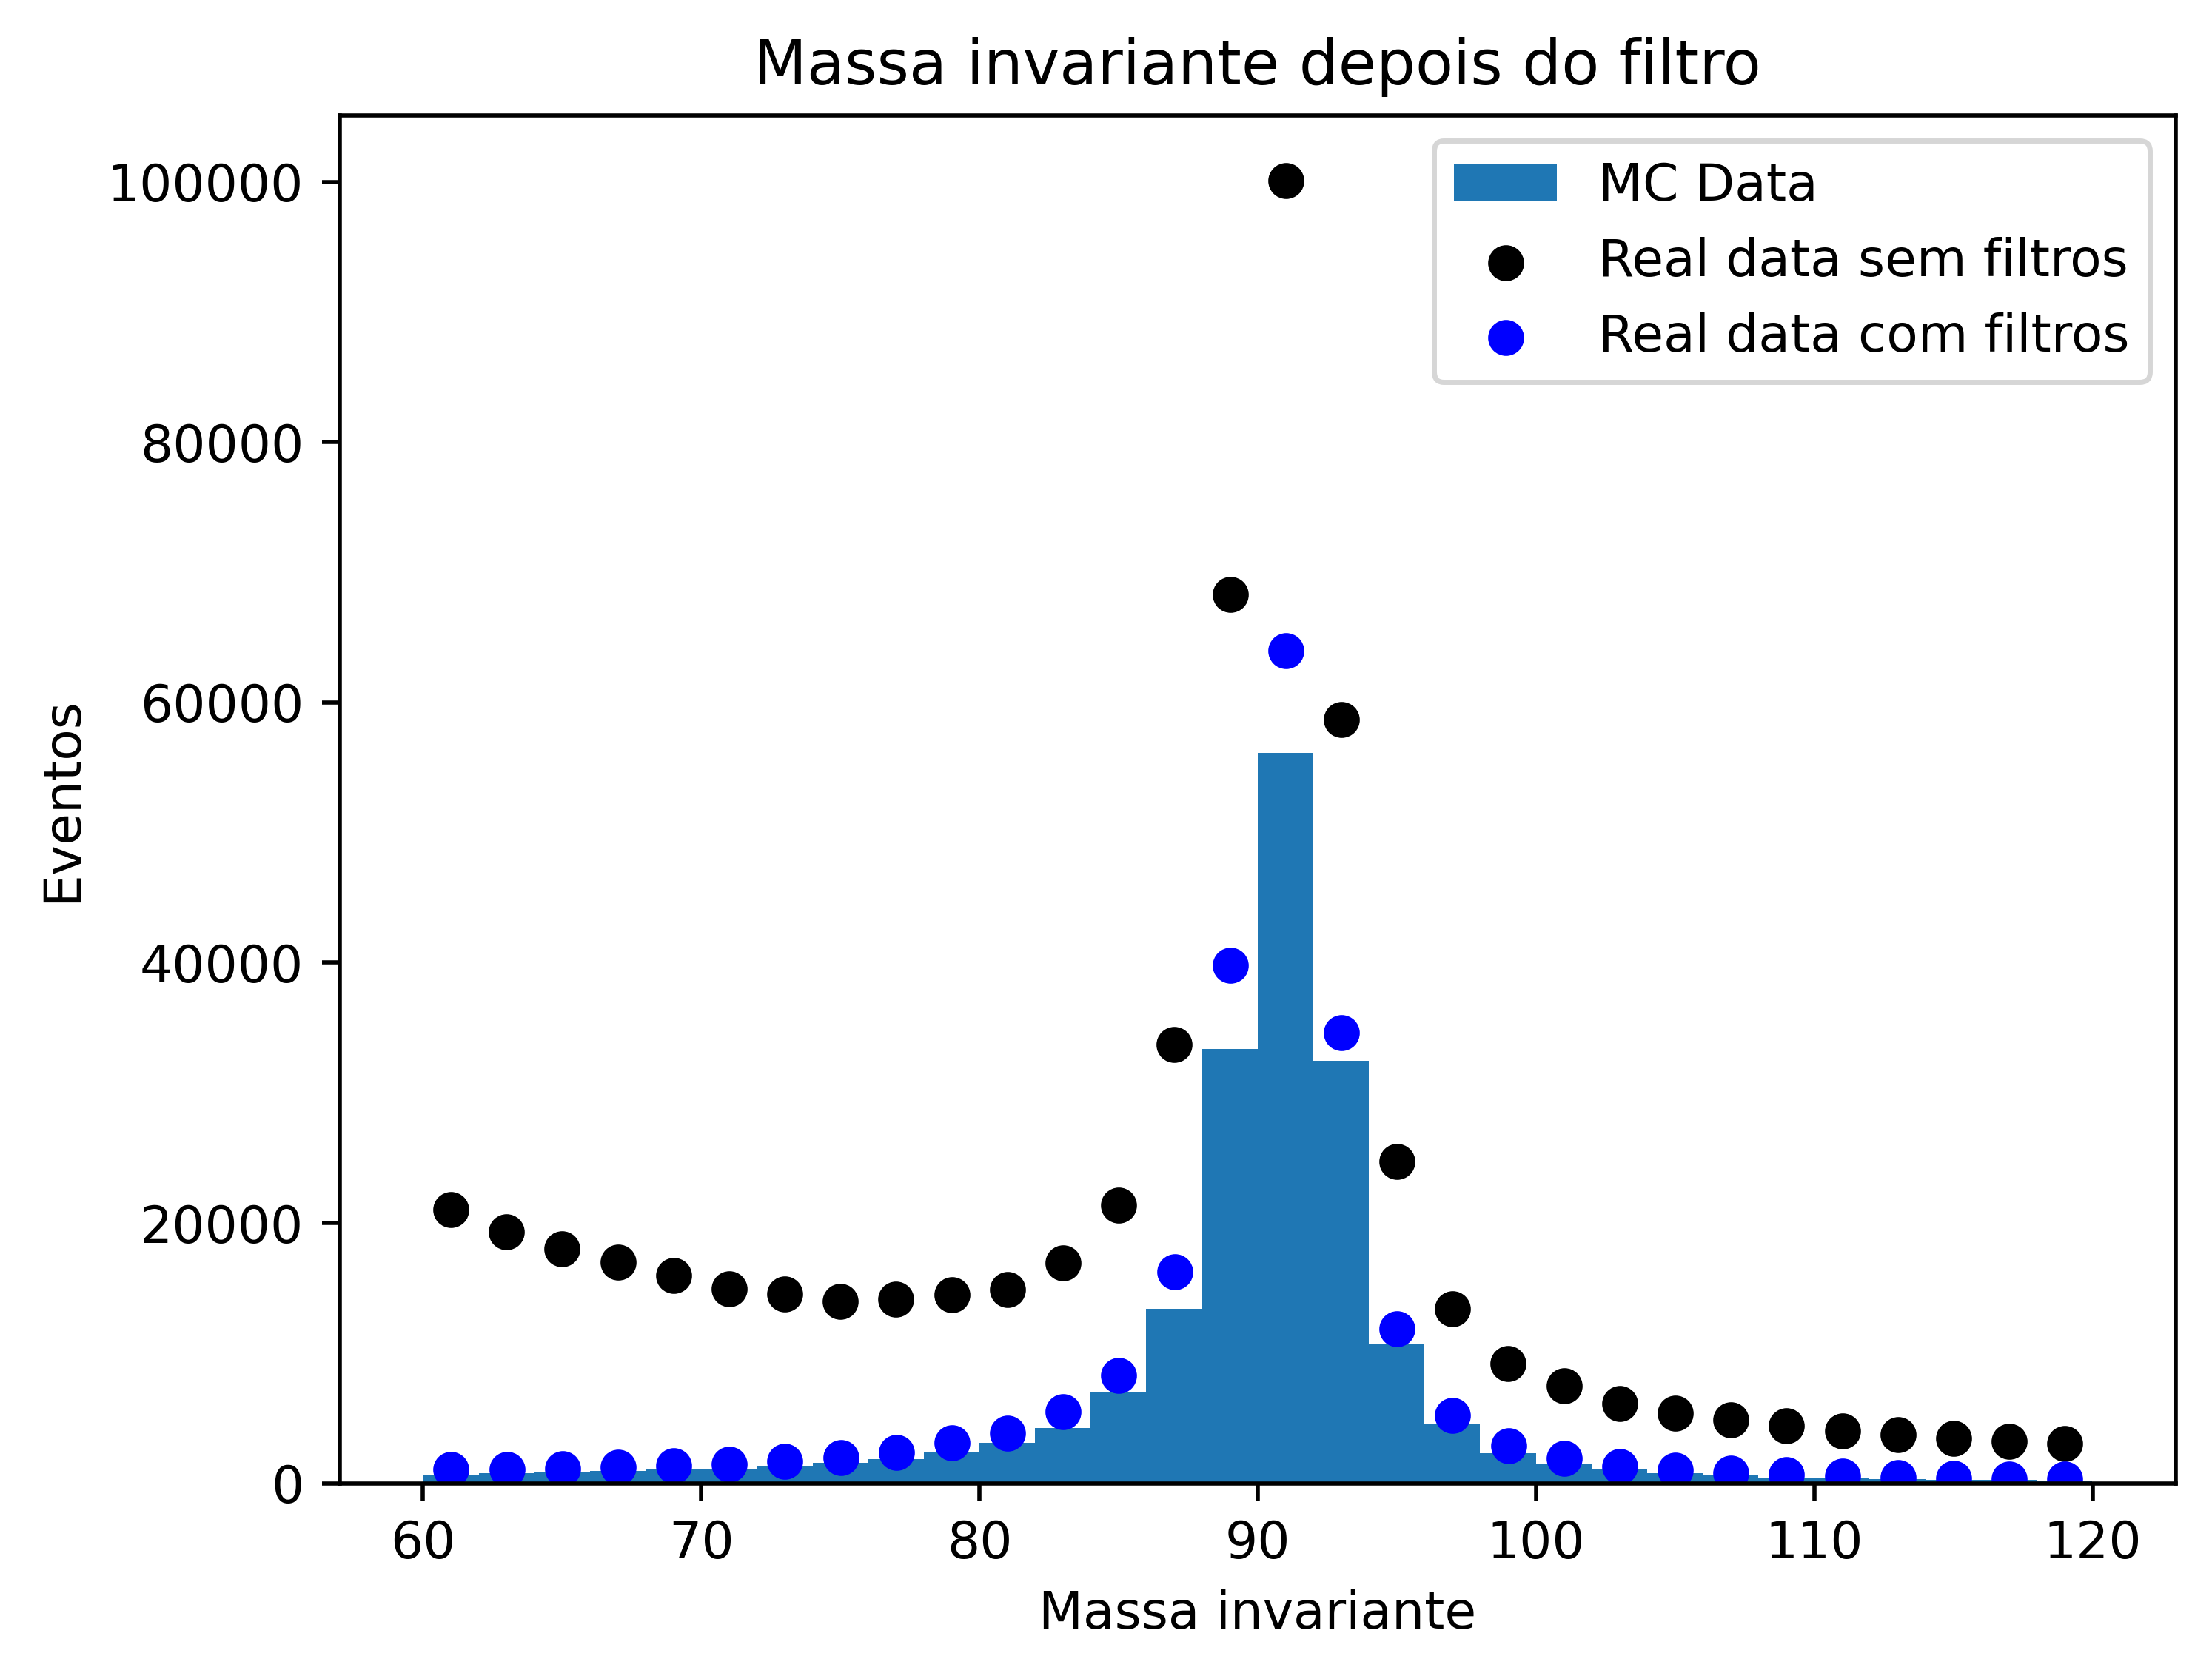

In [66]:
plt.figure(dpi=DPI)
plt.hist(mass_filtered, bins=BINS, label="MC Data")
plt.scatter(bin_centers, hist_counts, label="Real data sem filtros", color="black",)
plt.scatter(bin_centers_filtered, hist_counts_filtered, color="blue", label="Real data com filtros")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.legend()
plt.title("Massa invariante depois do filtro")
plt.show()

Podemos agora fazer o cálculo:

# FINAL DO NOTEBOOK